  0%|          | 0/3 [00:00<?, ?it/s]

500 treatment_random 1.8136339572398923
500 treatment_dynamic 0.9117408750582113
500 treatment_network -0.006517606539888643
500 treatment_combined 0.37218281812778115


 33%|███▎      | 1/3 [00:08<00:17,  8.97s/it]

1000 treatment_random 1.5070390298704606
1000 treatment_dynamic 0.7883981808975077
1000 treatment_network 0.10356247041820899
1000 treatment_combined 0.4186379396176533


 67%|██████▋   | 2/3 [00:19<00:09,  9.67s/it]

10000 treatment_random 1.4669530987123145
10000 treatment_dynamic 0.8206162246574222
10000 treatment_network 0.09172591822596454
10000 treatment_combined 0.39823507921562523


100%|██████████| 3/3 [00:36<00:00, 12.00s/it]


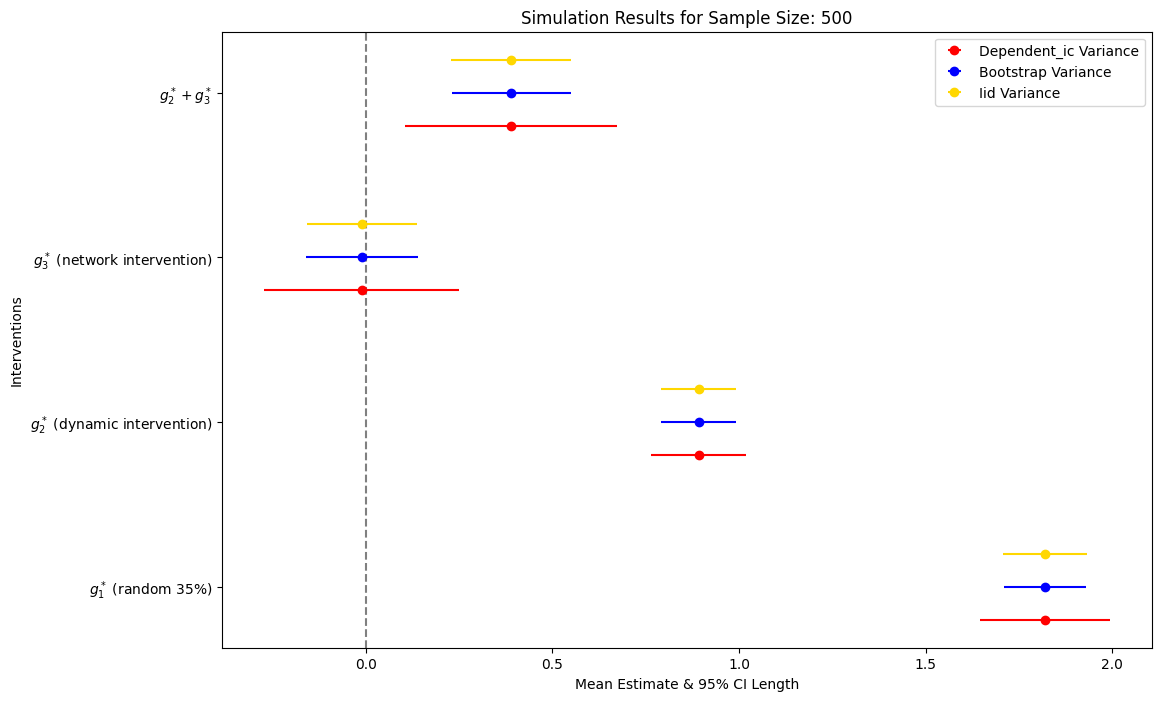

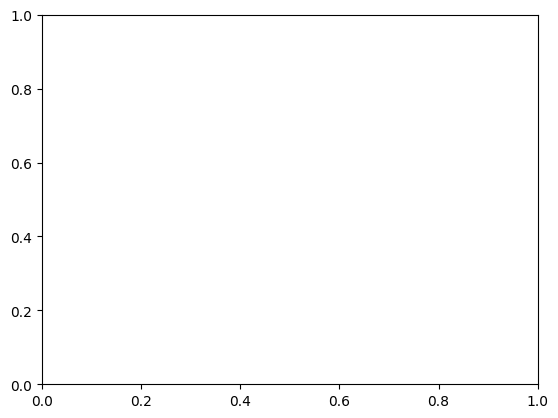

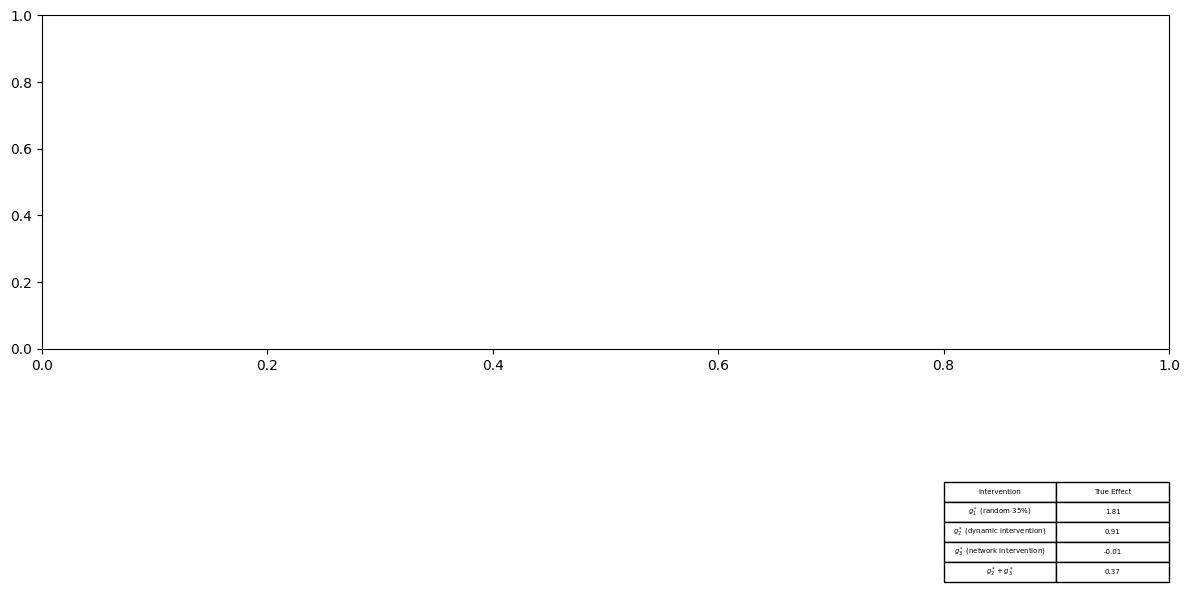

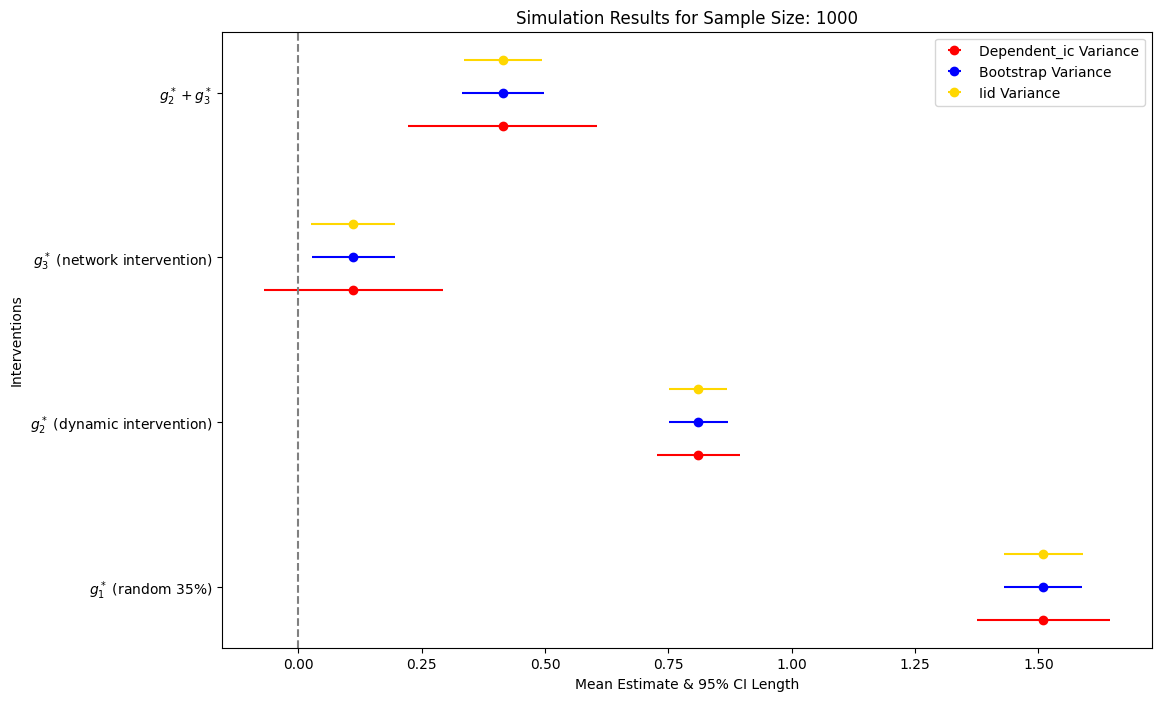

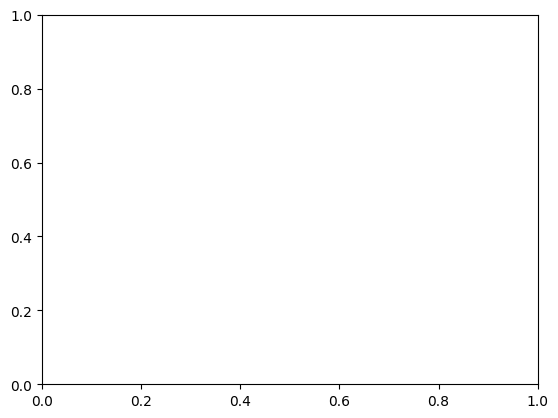

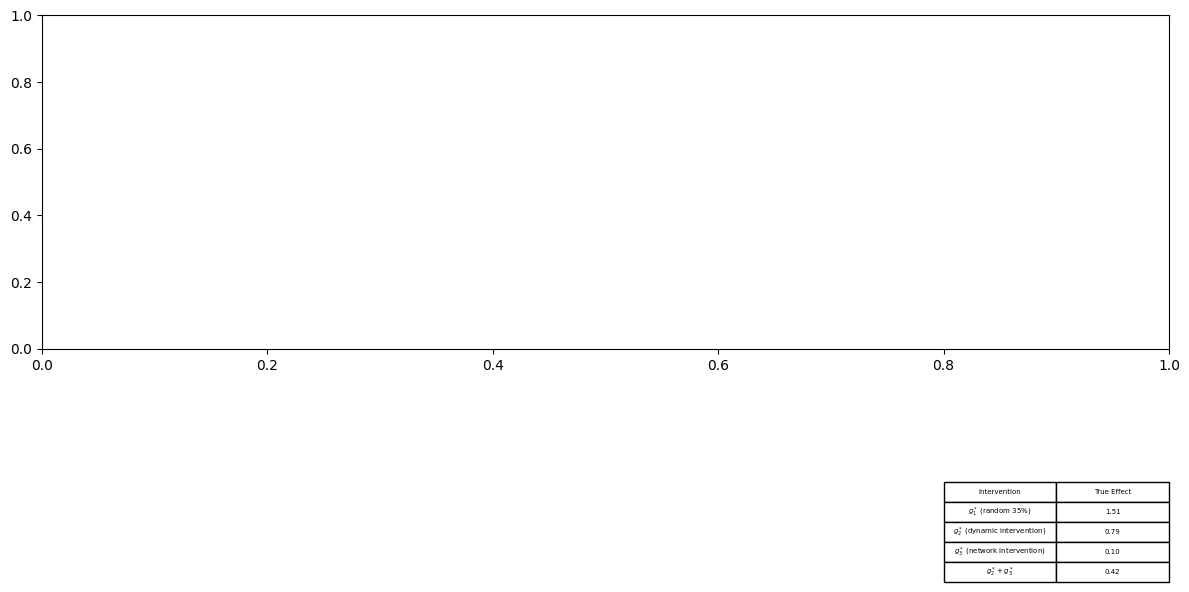

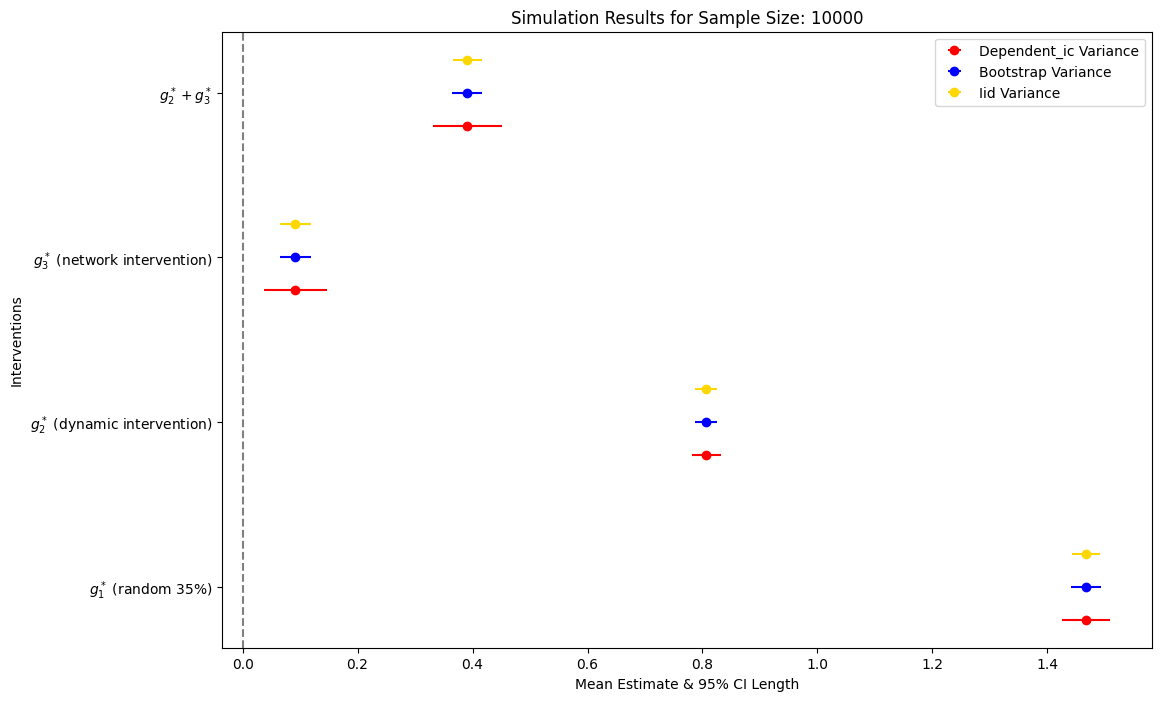

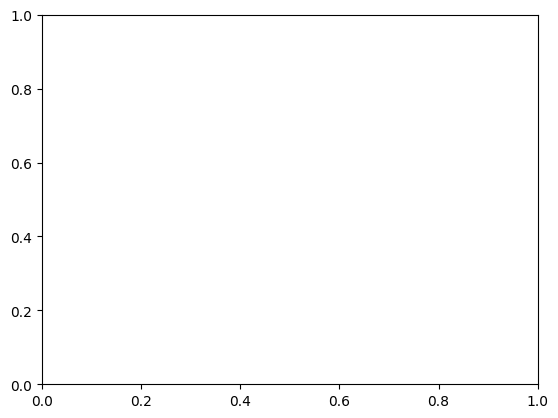

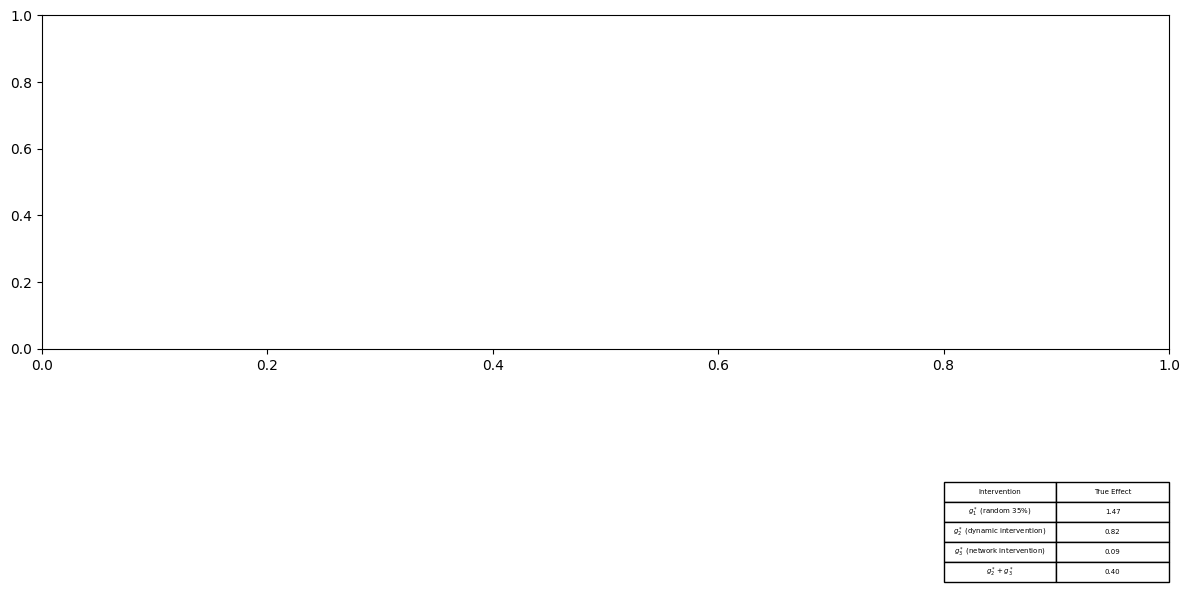

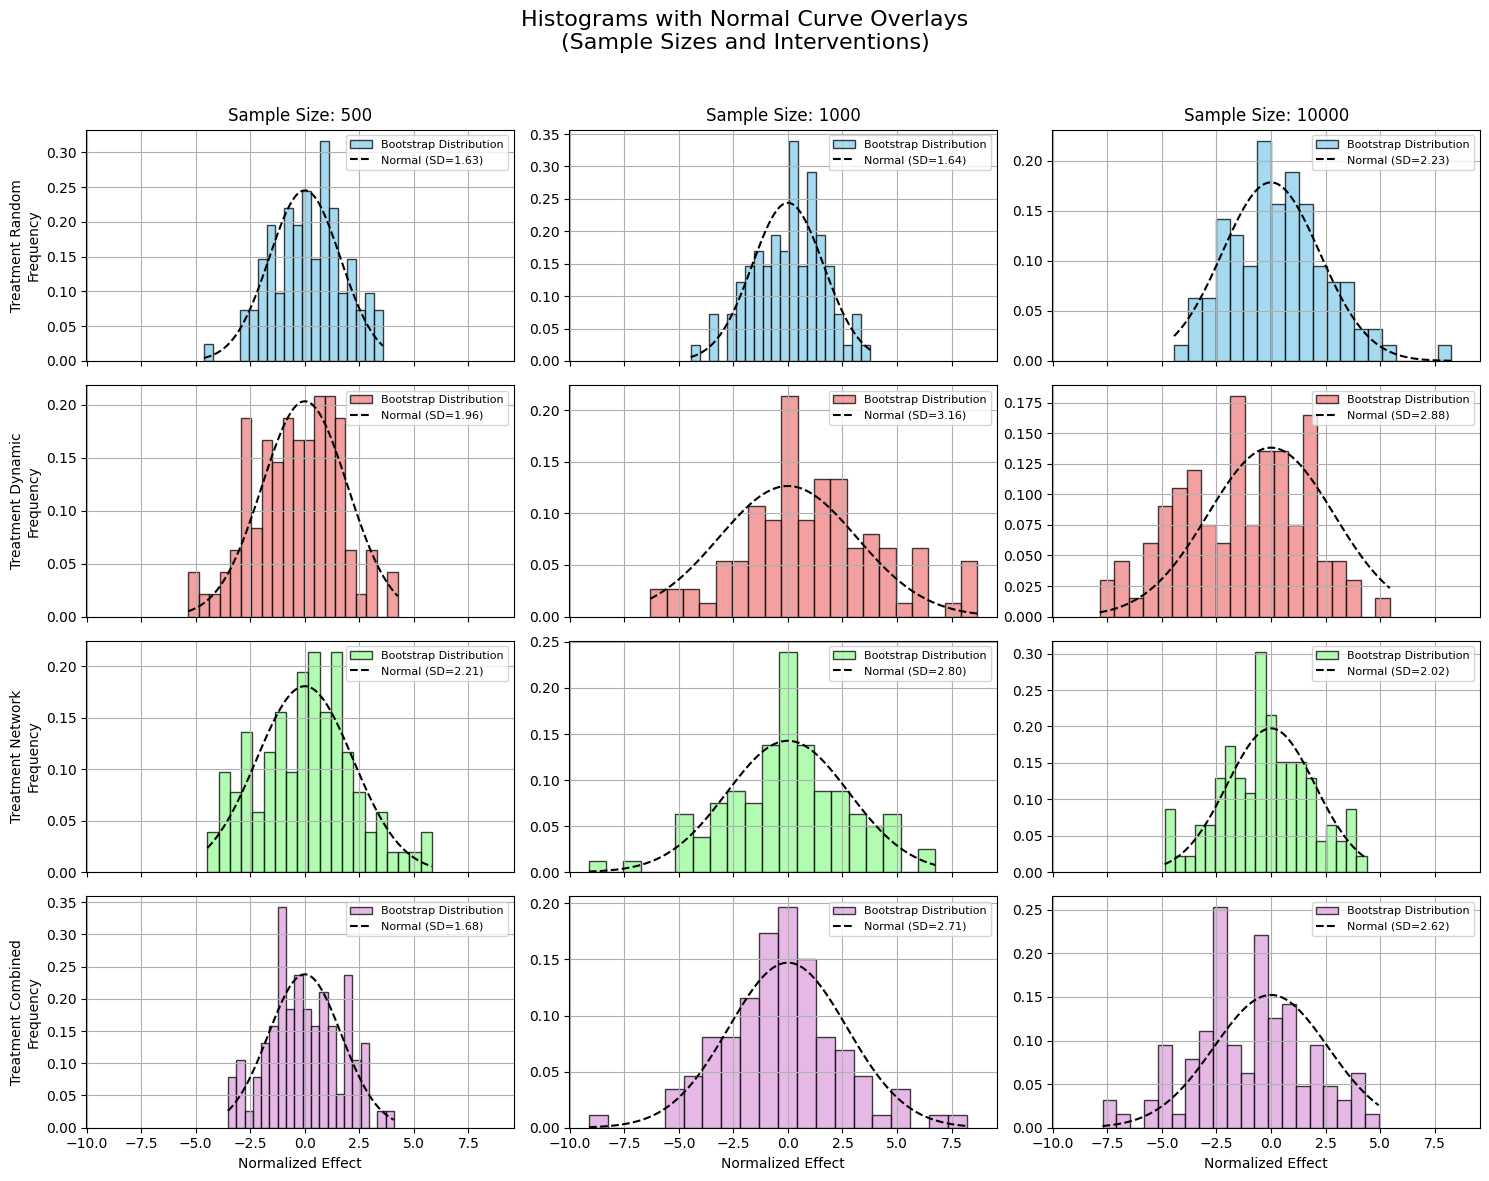

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper function: Generate a preferential attachment network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper function: Simulate node-level data and outcomes
def simulate_network_data(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Treatment assignment (various interventions)
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    neighbors_treatment = np.array([np.mean([data.loc[neighbor, 'treatment_random'] for neighbor in G.neighbors(node)])
                                     for node in G.nodes])
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    #print(data.head())
    return data



# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

def true(data, treatment_col, outcome_col):
    treated = data[data[treatment_col] == 1][outcome_col]
    untreated = data[data[treatment_col] == 0][outcome_col]
    effect = treated.mean() - untreated.mean()
    return effect

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=500):
    if method == 'dependent_ic':
        # Influence curve-based variance (accounts for network dependence)
        A = data[treatment_col]
        Y = data[outcome_col]
        clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
        residual = Y - data['Y_pred']
        ic = clever_covariate * residual
        variance = np.var(ic) / len(data)
    elif method == 'bootstrap':
        # Bootstrap variance
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=1, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        # IID-based variance (ignores network dependence)
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        variance = var_treated + var_untreated
    elif method == 'true':

        variance = 0
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return variance

# Visualization Function
def visualize_results_separate(results_df):
    """
    Create separate plots for each sample size, ensuring non-overlapping intervals for each variance method.
    Also, display a table of true effects in one corner of each plot.
    """
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}

    sample_sizes = results_df['Sample Size'].unique()

    # Compute true values for the table
    true_effects = {}
    for sample_size in sample_sizes:
        G = generate_preferential_attachment_network(sample_size, m=3, seed=42)
        data = simulate_network_data(G)
        for intervention in interventions_labels.keys():
            true_effects[(sample_size, intervention)] = true(data, intervention, 'outcome')

    for sample_size in sample_sizes:
        subset = results_df[results_df['Sample Size'] == sample_size]

        plt.figure(figsize=(12, 8))
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            y_positions = np.arange(len(method_data)) + method_offsets[method]  # Apply offset

            plt.errorbar(
                method_data['Effect'],
                y_positions,
                xerr=method_data['CI Length'],
                fmt='o',
                label=f"{method.capitalize()} Variance",
                color=methods_colors[method]
            )

        plt.yticks(np.arange(len(subset['Intervention'].unique())),
                   [interventions_labels[i] for i in subset['Intervention'].unique()])
        plt.axvline(0, color='gray', linestyle='--')
        plt.xlabel("Mean Estimate & 95% CI Length")
        plt.ylabel("Interventions")
        plt.title(f"Simulation Results for Sample Size: {sample_size}")
        plt.legend()
        plt.show()
        plt.cla()
        # Create table of true effects
        table_data = [
            [interventions_labels[intervention], f"{true_effects[(sample_size, intervention)]:.2f}"]
            for intervention in interventions_labels.keys()
        ]
        col_labels = ["Intervention", "True Effect"]
        plt.figure(figsize=(12, 8))
        plt.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='top right', bbox=[0.8, -0.7, 0.2, 0.3])

        plt.tight_layout()
        plt.show()



# Main Simulation Function
def run_simulation_with_separate_plots():
    """Run the simulation and generate separate plots for each sample size."""
    sample_sizes = [500, 1000, 10000]
    interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined']
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    results = []

    for n in tqdm(sample_sizes):
        G = generate_preferential_attachment_network(n, m=3, seed=42)
        data = simulate_network_data(G)

        for intervention in interventions:
            effect, variance, updated_data = estimate_tmle(data, treatment_col=intervention, outcome_col='outcome', covariates=['baseline', 'covariate_2', 'covariate_3'])
            print(n,intervention,true(data,intervention, outcome_col='outcome') )
            for method in variance_methods:
                method_variance = compute_variance(updated_data, intervention, 'outcome', method=method)
                ci_length = 1.96 * np.sqrt(method_variance)
                results.append({
                    'Sample Size': n,
                    'Intervention': intervention,
                    'Method': method,
                    'Effect': effect,
                    'CI Length': ci_length,
                })

    results_df = pd.DataFrame(results)
    visualize_results_separate(results_df)

# Run the simulation and generate separate plots
run_simulation_with_separate_plots()

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Updated Histogram Visualization Function
def plot_histograms_with_normal_overlay(sample_sizes, interventions, num_bootstrap=100):
    """
    Generate histograms with normal distribution overlay for each sample size and intervention.
    Arrange the plots side-by-side for sample sizes, with stacked interventions for each size.
    """
    fig, axes = plt.subplots(len(interventions), len(sample_sizes), figsize=(15, 12), sharex=True, sharey=False)
    fig.subplots_adjust(wspace=0.4, hspace=0.6)
    colors = ['skyblue', 'lightcoral', 'palegreen', 'plum']

    for col, n in enumerate(sample_sizes):
        G = generate_preferential_attachment_network(n, m=3, seed=42)
        data = simulate_network_data(G)

        for row, intervention in enumerate(interventions):
            true_effect = true(data, treatment_col=intervention, outcome_col='outcome')

            # Perform bootstrap to get estimates for normalization
            bootstrap_estimates = []
            for _ in range(num_bootstrap):
                sampled_data = data.sample(frac=1, replace=True)
                effect, variance, sampled_data = estimate_tmle(
                    sampled_data,
                    treatment_col=intervention,
                    outcome_col='outcome',
                    covariates=['baseline', 'covariate_2', 'covariate_3']
                )
                bootstrap_estimates.append(effect)

            # Normalize bootstrap estimates
            variance = compute_variance(sampled_data, intervention, 'outcome', method='bootstrap', num_bootstrap=num_bootstrap)
            std_dev = np.sqrt(variance)
            normalized_estimates = [(est - true_effect) / std_dev for est in bootstrap_estimates]

            # Calculate standard deviation of the histogram data
            histogram_std_dev = np.std(normalized_estimates)

            # Plot histogram
            ax = axes[row, col]
            ax.hist(normalized_estimates, bins=20, alpha=0.75, color=colors[row], edgecolor='black', density=True, label='Bootstrap Distribution')

            # Overlay normal distribution using histogram standard deviation
            x_vals = np.linspace(min(normalized_estimates), max(normalized_estimates), 100)
            y_vals = stats.norm.pdf(x_vals, 0, histogram_std_dev)  # Use histogram's calculated standard deviation
            ax.plot(x_vals, y_vals, color='black', linestyle='--', label=f'Normal (SD={histogram_std_dev:.2f})')

            # Titles and labels
            if row == 0:
                ax.set_title(f"Sample Size: {n}")
            if col == 0:
                ax.set_ylabel(f"{intervention.replace('_', ' ').title()}\nFrequency")
            if row == len(interventions) - 1:
                ax.set_xlabel("Normalized Effect")

            ax.legend(loc='upper right', fontsize=8)
            ax.grid(True)

    plt.suptitle("Histograms with Normal Curve Overlays\n(Sample Sizes and Interventions)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to fit the suptitle
    plt.show()

# Define parameters for the histograms
sample_sizes = [500, 1000, 10000]
interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined']

# Generate histograms with normal overlays
plot_histograms_with_normal_overlay(sample_sizes, interventions)







In [ ]:
def simulate_network_data_with_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    data['degree_centrality'] = pd.Series(degree_centrality)

    # Treatment assignment
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    neighbors_treatment = np.array([np.mean([data.loc[neighbor, 'treatment_random'] for neighbor in G.neighbors(node)])
                                     for node in G.nodes])
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    return data

def analyze_influence_by_centrality(data):
    # Handle duplicate edges by dropping duplicates using 'duplicates' argument
    bins = pd.qcut(data['degree_centrality'].rank(method="first"), q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    data['centrality_group'] = bins

    # Calculate average treatment effect and network effect by group
    group_analysis = data.groupby('centrality_group').agg(
        avg_degree=('degree_centrality', 'mean'),
        avg_treatment_effect=('treatment_random', 'mean'),
        avg_outcome=('outcome', 'mean'),
        outcome_variance=('outcome', 'var')
    )
    return group_analysis


In [ ]:
def plot_influence_by_centrality(data):
    group_analysis = analyze_influence_by_centrality(data)

    # Plot average outcome and variance by centrality group
    plt.figure(figsize=(10, 6))
    plt.bar(group_analysis.index, group_analysis['avg_outcome'], alpha=0.7, label='Avg. Outcome')
    plt.errorbar(group_analysis.index, group_analysis['avg_outcome'],
                 yerr=1.96 * np.sqrt(group_analysis['outcome_variance']),
                 fmt='o', color='red', label='95% CI')
    plt.xlabel("Centrality Group")
    plt.ylabel("Average Outcome")
    plt.title("Influence of Degree Centrality on Outcomes")
    plt.legend()
    plt.tight_layout()
    plt.show()


<ipython-input-18-bd09440cac85>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_analysis = data.groupby('centrality_group').agg(


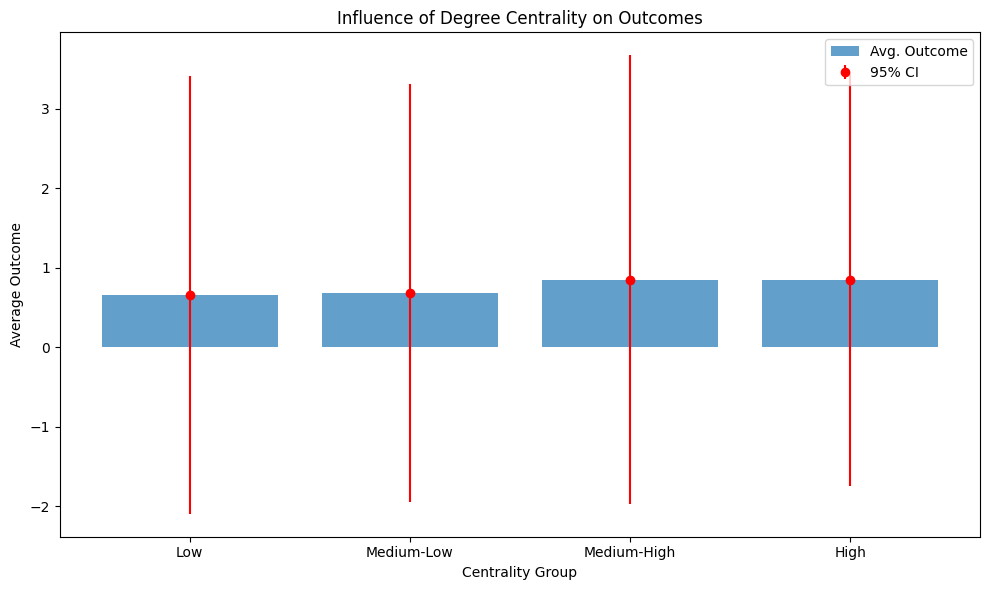

In [ ]:
def run_influence_analysis():
    G = generate_preferential_attachment_network(1000, m=3, seed=42)
    data = simulate_network_data_with_influence(G)
    plot_influence_by_centrality(data)

run_influence_analysis()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set a universally available style for aesthetics
plt.style.use("ggplot")

# Generate data
n_points = 10
W = np.linspace(0, 10, n_points)

# Define functions for interventions
static_value = 5
dynamic_function = lambda w: 2 * w + 1
stochastic_function = lambda w: np.random.normal(2 * w + 1, scale=2, size=len(w))

# Create separate animations for each type
output_files = []

def create_animation(type_name, output_file, function, frame_func=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, 10)
    ax.set_ylim(-5, 25)
    ax.set_title(f"{type_name} Intervention", fontsize=16, weight='bold')
    ax.set_xlabel("Covariates (W)", fontsize=12)
    ax.set_ylabel("Exposure (V*)", fontsize=12)

    # Scatter points
    scatter, = ax.plot([], [], 'o', markersize=8, color="steelblue", label="Points")
    ax.legend()

    # Initialization function
    def init():
        scatter.set_data([], [])
        return scatter,

    # Animation function
    def animate(frame):
        if frame_func:
            y = frame_func(W, frame)
        else:
            y = function(W)
        scatter.set_data(W, y)
        return scatter,

    ani = FuncAnimation(fig, animate, frames=100, init_func=init, blit=True)
    ani.save(output_file, fps=30, extra_args=['-vcodec', 'libx264'])
    plt.close(fig)
    output_files.append(output_file)

# 1. Static Intervention
create_animation(
    "Static",
    "static_intervention.mp4",
    lambda w: np.full_like(w, static_value)
)

# 2. Dynamic Intervention
create_animation(
    "Dynamic",
    "dynamic_intervention.mp4",
    lambda w: dynamic_function(w)
)

# 3. Stochastic Intervention
create_animation(
    "Stochastic",
    "stochastic_intervention.mp4",
    lambda w: stochastic_function(w)
)

# Download the animations
from google.colab import files
for file in output_files:
    files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the Facebook Social Circles Dataset
edges_file = "facebook_combined.txt"  # File containing the edges

# Load edges
edges = pd.read_csv(edges_file, sep=' ', names=['node_1', 'node_2'])
G = nx.from_pandas_edgelist(edges, source='node_1', target='node_2')

# Step 2: Generate node-level features dynamically
node_features = pd.DataFrame(index=G.nodes)
node_features['degree'] = pd.Series(dict(G.degree()))
node_features['clustering_coefficient'] = pd.Series(nx.clustering(G))
node_features['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G, normalized=True))

# Step 3: Create synthetic pairs and labels
np.random.seed(42)
pairs = edges.sample(1000, replace=False)  # Sample 1000 edges for analysis
pairs['label'] = np.random.choice([0, 1], size=len(pairs), p=[0.5, 0.5])  # Random binary labels

# Debugging: Check label column before preprocessing
print("Initial label column:", pairs['label'].unique(), pairs['label'].dtype)

# Step 4: Validate the `label` column
# Remove any rows with NaNs in the label column
pairs = pairs.dropna(subset=['label'])

# Convert `label` column to integers and validate its values
pairs['label'] = pairs['label'].astype(int)
assert pairs['label'].isin([0, 1]).all(), "Labels must only contain binary values (0 or 1)!"

# Debugging: Check label column after conversion
print("After conversion, label column:", pairs['label'].unique(), pairs['label'].dtype)

# Step 5: Feature engineering for node pairs
def calculate_pairwise_features(row, node_features):
    node_1_features = node_features.loc[row['node_1']]
    node_2_features = node_features.loc[row['node_2']]
    features = {
        'degree_node_1': node_1_features['degree'],
        'degree_node_2': node_2_features['degree'],
        'clustering_coefficient_diff': abs(node_1_features['clustering_coefficient'] - node_2_features['clustering_coefficient']),
        'betweenness_centrality_diff': abs(node_1_features['betweenness_centrality'] - node_2_features['betweenness_centrality']),
    }
    return pd.Series(features)

pair_features = pairs.apply(lambda row: calculate_pairwise_features(row, node_features), axis=1)
pairs = pd.concat([pairs.reset_index(drop=True), pair_features], axis=1)

# Step 6: Preprocessing for TMLE
numeric_cols = pairs.select_dtypes(include=[np.number]).columns

# Fill NaNs in numeric columns with the median
pairs[numeric_cols] = pairs[numeric_cols].fillna(pairs[numeric_cols].median())

# Standardize covariates
scaler = StandardScaler()
pairs[numeric_cols] = scaler.fit_transform(pairs[numeric_cols])

# Step 7: Define TMLE estimation function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Check for NaNs before model training
    if data[covariates].isna().sum().sum() > 0:
        raise ValueError(f"NaNs found in covariates: {data[covariates].isna().sum()}")

    # Exposure model
    ps_model = LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced')
    ps_model.fit(data[covariates], data[treatment_col])
    data['ps'] = ps_model.predict_proba(data[covariates])[:, 1]

    # Outcome model
    outcome_model = LinearRegression()
    outcome_model.fit(pd.concat([data[covariates], data[[treatment_col]]], axis=1), data[outcome_col])
    data['Y_pred'] = outcome_model.predict(pd.concat([data[covariates], data[[treatment_col]]], axis=1))

    # TMLE targeting step
    clever_covariate = (data[treatment_col] - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (data[outcome_col] - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    if len(treated) == 0 or len(untreated) == 0:
        print(f"Skipping {treatment_col}: Empty treated or untreated group.")
        return np.nan, np.nan, data

    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated) if len(treated) > 0 else np.nan
    var_untreated = untreated.var() / len(untreated) if len(untreated) > 0 else np.nan
    variance = var_treated + var_untreated
    return effect, variance, data

# Step 8: Variance estimation
def compute_variance(data, treatment_col, outcome_col, method='bootstrap', num_bootstrap=500):
    if method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sample = data.sample(frac=1, replace=True)
            treated = sample[sample[treatment_col] == 1]['Y_tilde']
            untreated = sample[sample[treatment_col] == 0]['Y_tilde']
            if len(treated) == 0 or len(untreated) == 0:
                continue
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        variance = np.var(bootstrap_estimates) if len(bootstrap_estimates) > 1 else np.nan
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated) if len(treated) > 0 else np.nan
        var_untreated = untreated.var() / len(untreated) if len(untreated) > 0 else np.nan
        variance = var_treated + var_untreated
    else:
        raise ValueError("Unsupported method.")
    return variance

# Step 9: Run TMLE analysis
def run_analysis(pairs, interventions, outcome_col, covariates):
    results = []
    for intervention in interventions:
        effect, variance, updated_data = estimate_tmle(
            pairs, treatment_col=intervention, outcome_col=outcome_col, covariates=covariates
        )
        if pd.notna(effect):
            bootstrap_variance = compute_variance(updated_data, intervention, outcome_col, method='bootstrap')
            iid_variance = compute_variance(updated_data, intervention, outcome_col, method='iid')
            results.append({'Intervention': intervention, 'Method': 'bootstrap', 'Effect': effect, 'Variance': bootstrap_variance})
            results.append({'Intervention': intervention, 'Method': 'iid', 'Effect': effect, 'Variance': iid_variance})
    return pd.DataFrame(results)

# Step 10: Define interventions and covariates
covariates = ['degree_node_1', 'degree_node_2', 'clustering_coefficient_diff', 'betweenness_centrality_diff']
interventions = ['degree_node_1', 'clustering_coefficient_diff', 'betweenness_centrality_diff']

# Run TMLE analysis
results = run_analysis(pairs, interventions, outcome_col='label', covariates=covariates)

# Visualize Results
def visualize_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 6))
    methods_colors = {'bootstrap': 'blue', 'iid': 'orange'}
    for intervention in results_df['Intervention'].unique():
        subset = results_df[results_df['Intervention'] == intervention]
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            effect = method_data['Effect'].values[0]
            ci_length = 1.96 * np.sqrt(method_data['Variance'].values[0])
            ax.errorbar(
                effect,
                intervention,
                xerr=ci_length,
                fmt='o',
                color=methods_colors[method],
                label=method if intervention == interventions[0] else ""
            )
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, label="No Effect")
    ax.set_title("TMLE Estimated Effects with 95% Confidence Intervals", fontsize=14)
    ax.set_xlabel("Effect Estimate", fontsize=12)
    ax.set_ylabel("Interventions", fontsize=12)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(results)

# Display Summary of Results
print("Summary of TMLE Analysis Results:")
print(results)


Initial label column: [0 1] int64
After conversion, label column: [0 1] int64


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

100%|██████████| 3/3 [00:41<00:00, 13.81s/it]


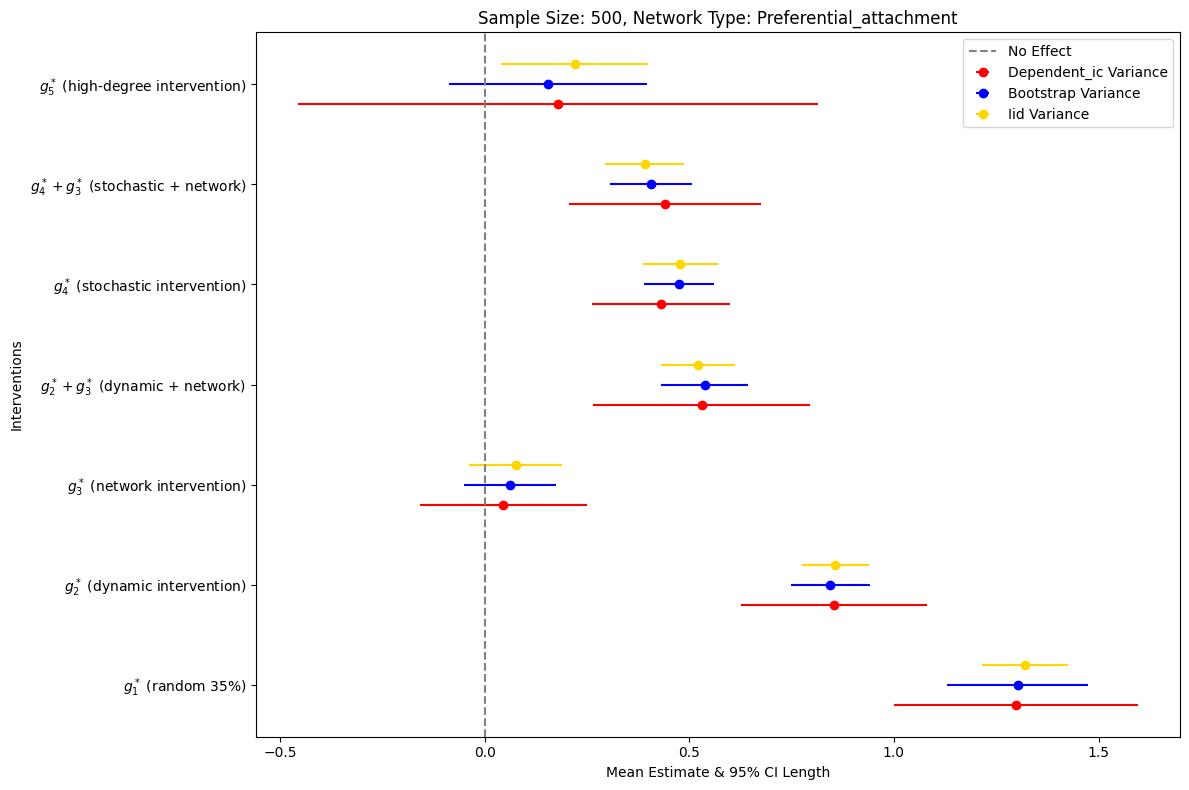

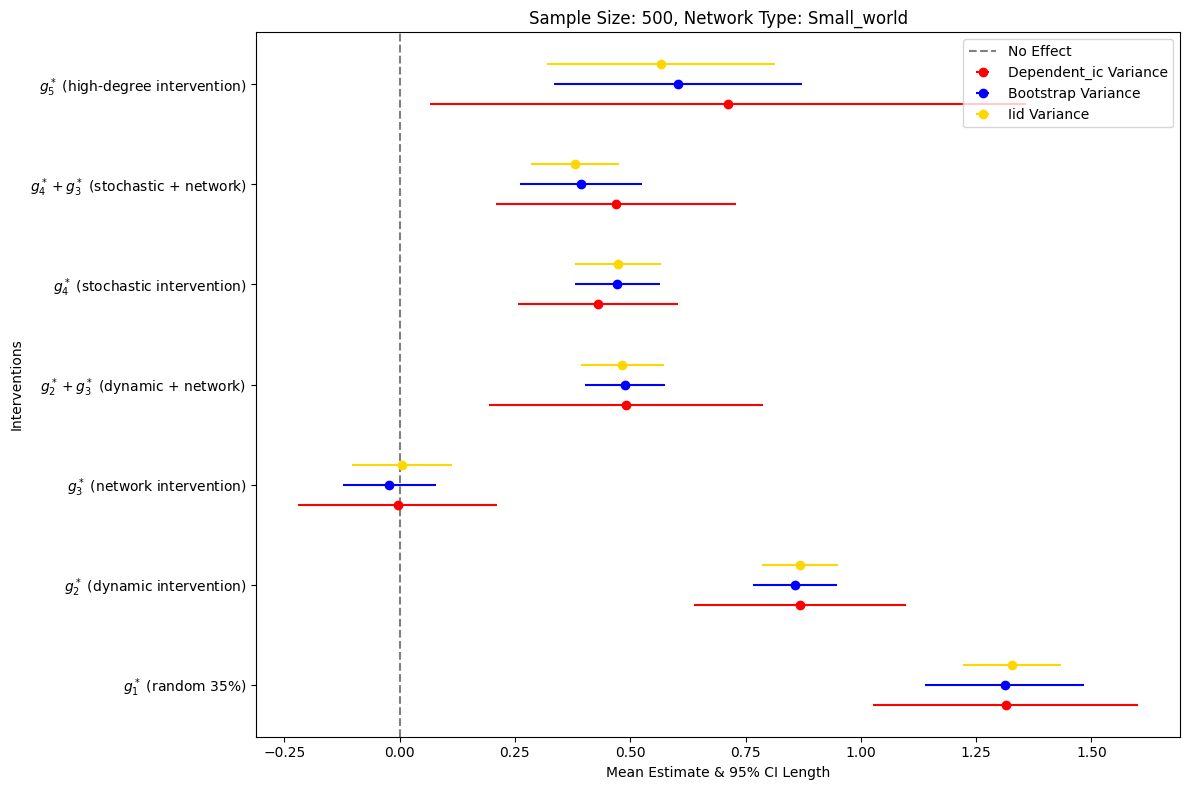

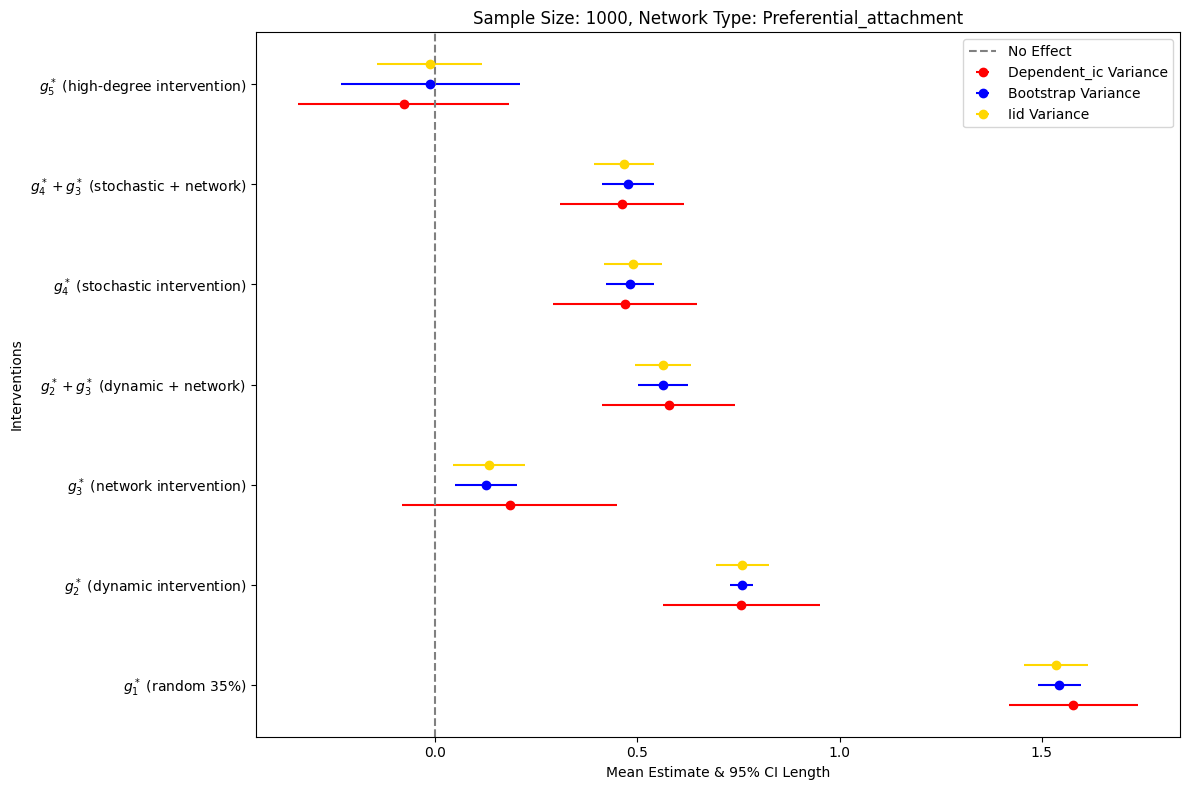

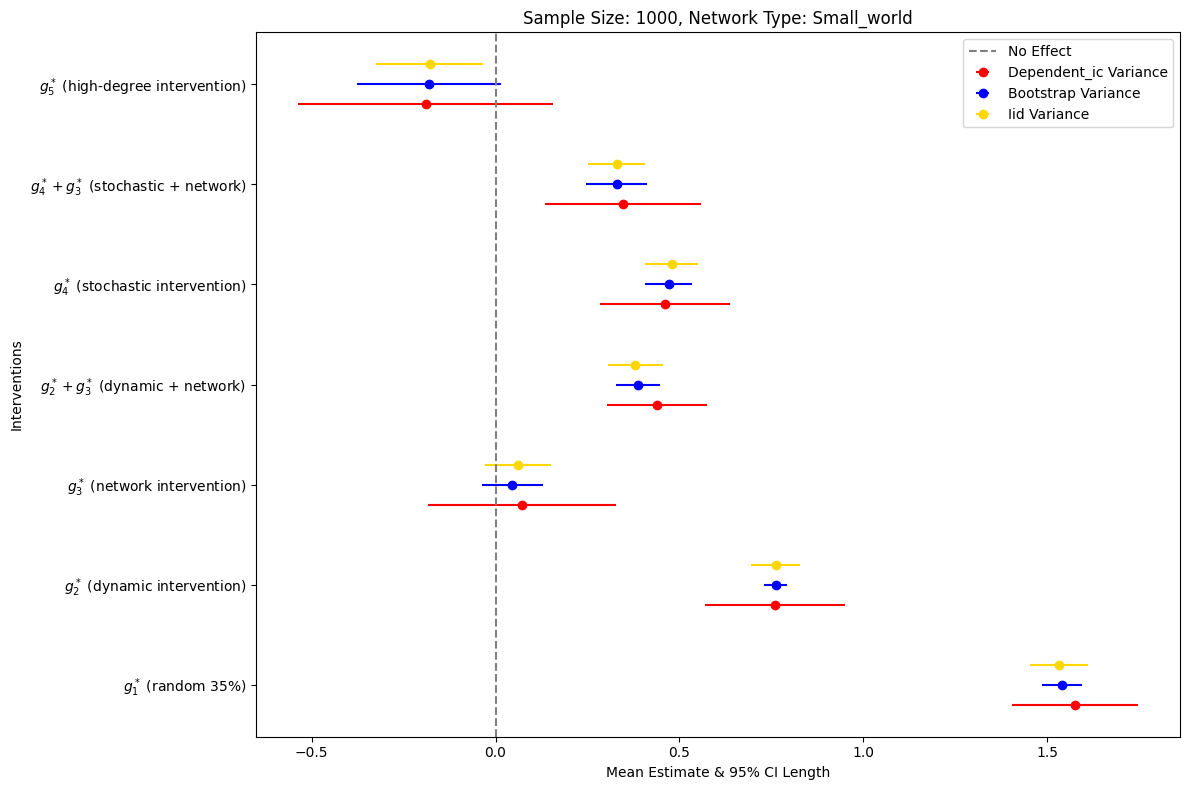

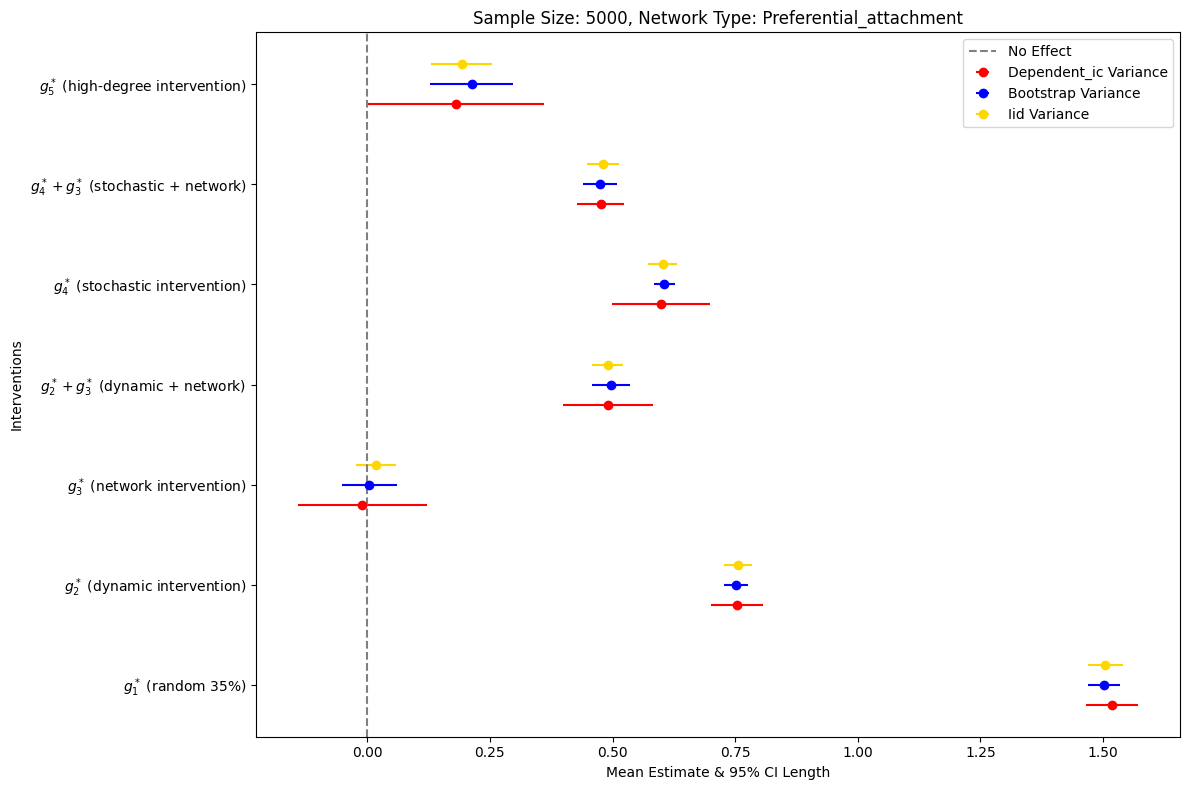

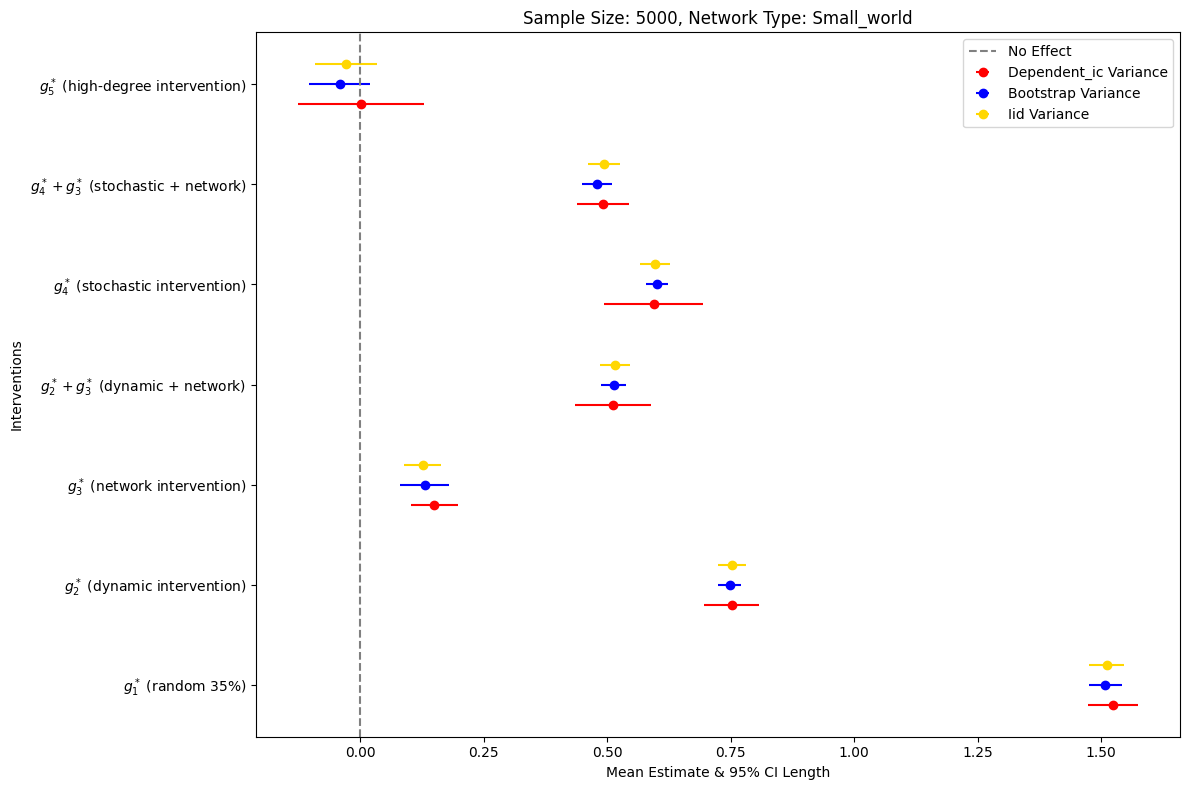

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data and Outcomes
def simulate_network_data(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Stochastic treatment: Probability proportional to baseline covariate
    probabilities = 1 / (1 + np.exp(-2 * data['baseline']))  # Sigmoid of baseline covariate
    data['stochastic_treatment'] = np.random.binomial(1, probabilities)

    # Combined stochastic and network-based intervention
    data['stochastic_network_combined'] = (
        (data['stochastic_treatment'] | data['treatment_network']).astype(int)
    )

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    return data

# Extend simulation data generation to include degree-based treatment
def simulate_network_data_with_degree_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    data = simulate_network_data(G, p_treatment, dynamic_threshold, network_influence)

    # Add degree information
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # High-degree treatment (nodes with degree above threshold are more likely treated)
    degree_threshold = np.percentile(degrees, 90)  # Top 10% most connected nodes
    data['treatment_high_degree'] = (degrees > degree_threshold).astype(int)

    # Adjust outcome to include excessive influence
    high_degree_influence = np.array([
        network_influence * sum(data.loc[list(G.neighbors(node)), 'treatment_high_degree']) / max(len(list(G.neighbors(node))), 1)
        for node in G.nodes
    ])
    data['outcome_with_influence'] = (
        data['outcome'] + 2.0 * high_degree_influence
    )

    return data

# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=10):
    if method == 'dependent_ic':
        tmle_bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            effect, _, _ = estimate_tmle(
                sampled_data, treatment_col, outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            tmle_bootstrap_estimates.append(effect)
        mean_estimate = np.mean(tmle_bootstrap_estimates)
        variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        mean_estimate = np.mean(bootstrap_estimates)
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        mean_estimate = treated.mean() - untreated.mean()
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return mean_estimate, variance

# Visualization Function
def visualize_results_by_sample_and_network(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'stochastic_treatment': r"$g_4^*$ (stochastic intervention)",
        'stochastic_network_combined': r"$g_4^* + g_3^*$ (stochastic + network)",
        'treatment_high_degree': r"$g_5^*$ (high-degree intervention)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}

    sample_sizes = results_df['Sample Size'].unique()
    network_types = results_df['Network Type'].unique()

    for sample_size in sample_sizes:
        for network_type in network_types:
            subset = results_df[(results_df['Sample Size'] == sample_size) &
                                (results_df['Network Type'] == network_type)]

            plt.figure(figsize=(12, 8))
            for method in subset['Method'].unique():
                method_data = subset[subset['Method'] == method]
                y_positions = np.arange(len(method_data)) + method_offsets[method]

                plt.errorbar(
                    method_data['Effect'],
                    y_positions,
                    xerr=method_data['CI Length'],
                    fmt='o',
                    label=f"{method.capitalize()} Variance",
                    color=methods_colors[method]
                )

            plt.yticks(
                np.arange(len(subset['Intervention'].unique())),
                [interventions_labels[i] for i in subset['Intervention'].unique()]
            )
            plt.axvline(0, color='gray', linestyle='--', label="No Effect")
            plt.xlabel("Mean Estimate & 95% CI Length")
            plt.ylabel("Interventions")
            plt.title(f"Sample Size: {sample_size}, Network Type: {network_type.capitalize()}")
            plt.legend()
            plt.tight_layout()
            plt.show()

# Main Simulation Function
def run_simulation_with_degree_influence():
    sample_sizes = [500, 1000, 5000]
    interventions = [
        'treatment_random',
        'treatment_dynamic',
        'treatment_network',
        'treatment_combined',
        'stochastic_treatment',
        'stochastic_network_combined',
        'treatment_high_degree'
    ]
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for n in tqdm(sample_sizes):
        for network_type in network_types:
            if network_type == 'preferential_attachment':
                G = generate_preferential_attachment_network(n, m=10, seed=42)
            elif network_type == 'small_world':
                G = generate_small_world_network(n, k=10, p=0.1, seed=42)

            data = simulate_network_data_with_degree_influence(G)
            for intervention in interventions:
                effect_tmle, variance_tmle, updated_data = estimate_tmle(
                    data, treatment_col=intervention, outcome_col='outcome_with_influence',
                    covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
                )
                for method in variance_methods:
                    effect, variance = compute_variance(updated_data, intervention, 'outcome_with_influence', method=method)
                    ci_length = 1.96 * np.sqrt(variance)
                    results.append({
                        'Sample Size': n,
                        'Network Type': network_type,
                        'Intervention': intervention,
                        'Method': method,
                        'Effect': effect,
                        'CI Length': ci_length,
                    })

    results_df = pd.DataFrame(results)
    visualize_results_by_sample_and_network(results_df)

# Run the extended simulation
run_simulation_with_degree_influence()


100%|██████████| 3/3 [07:49<00:00, 156.65s/it]


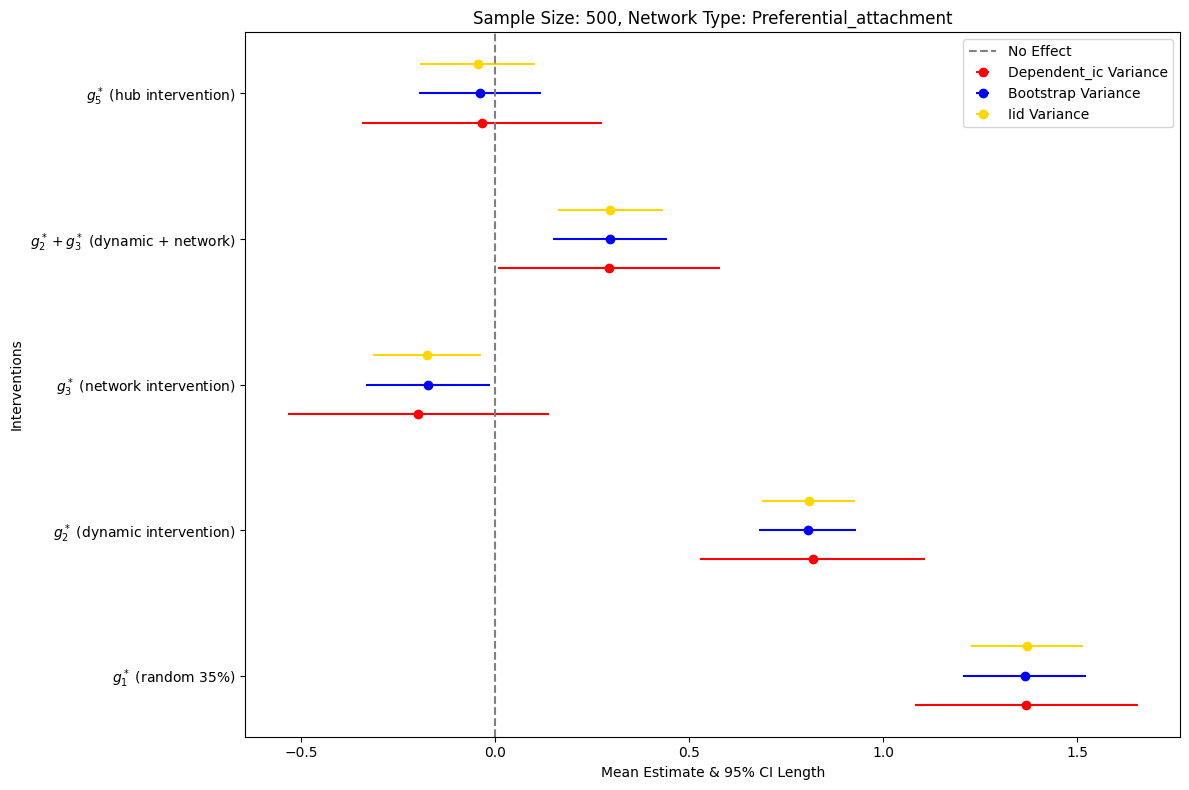

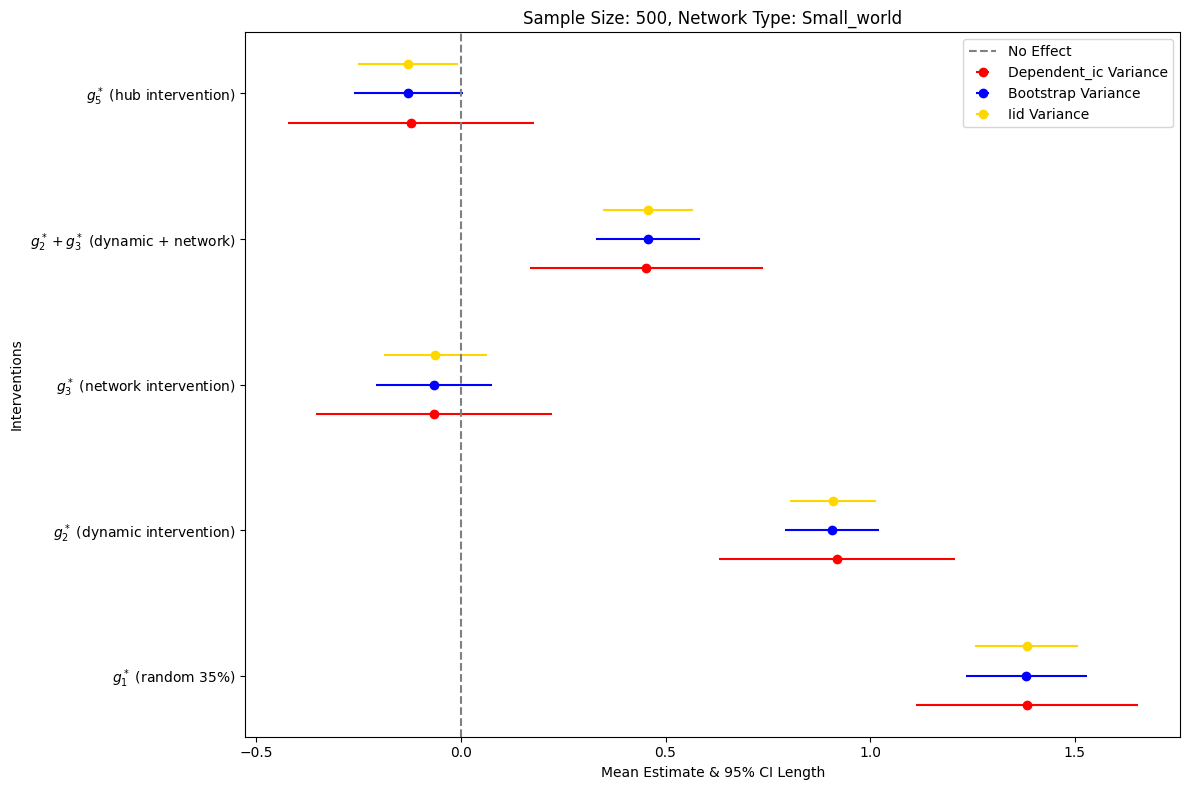

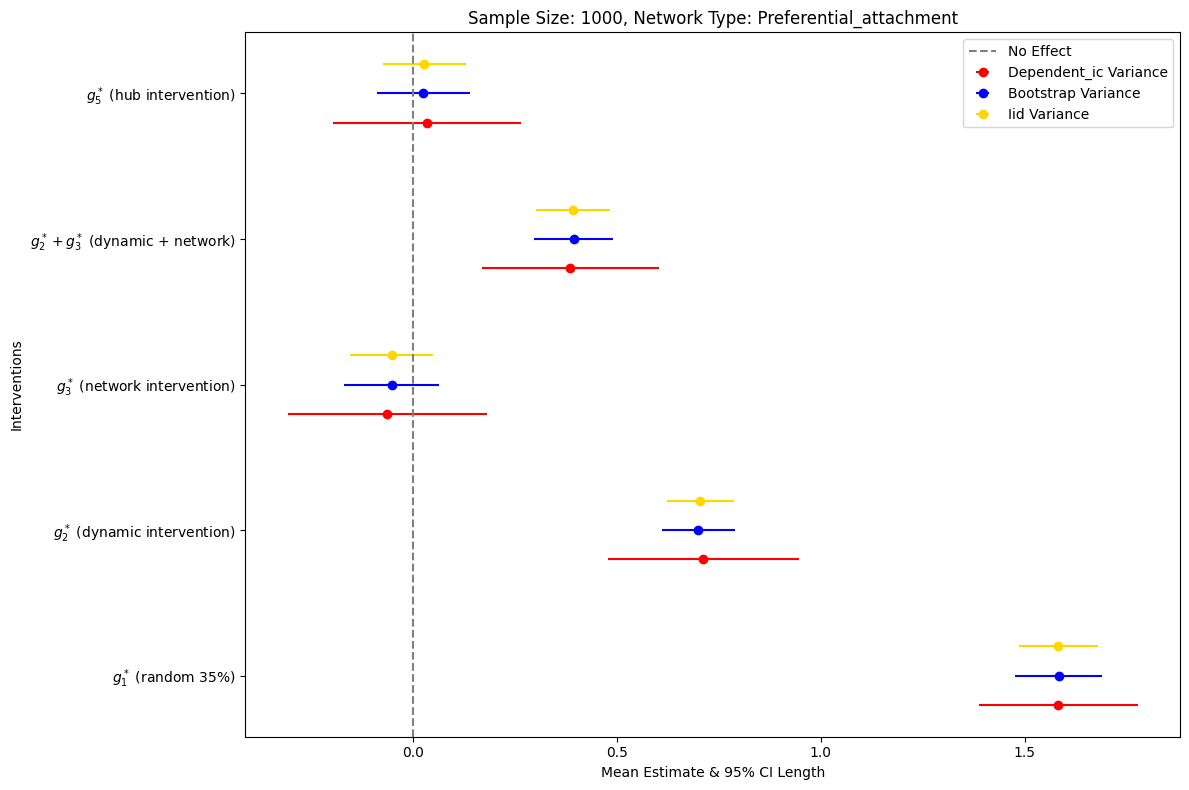

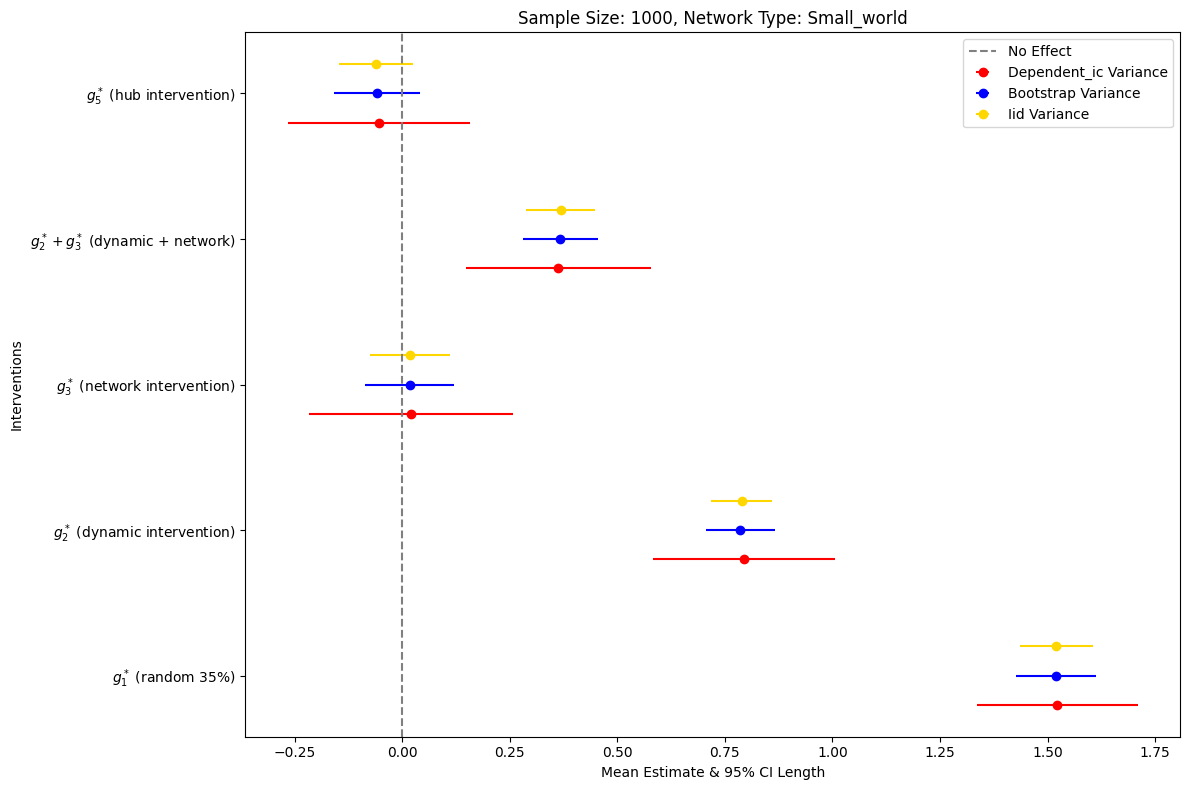

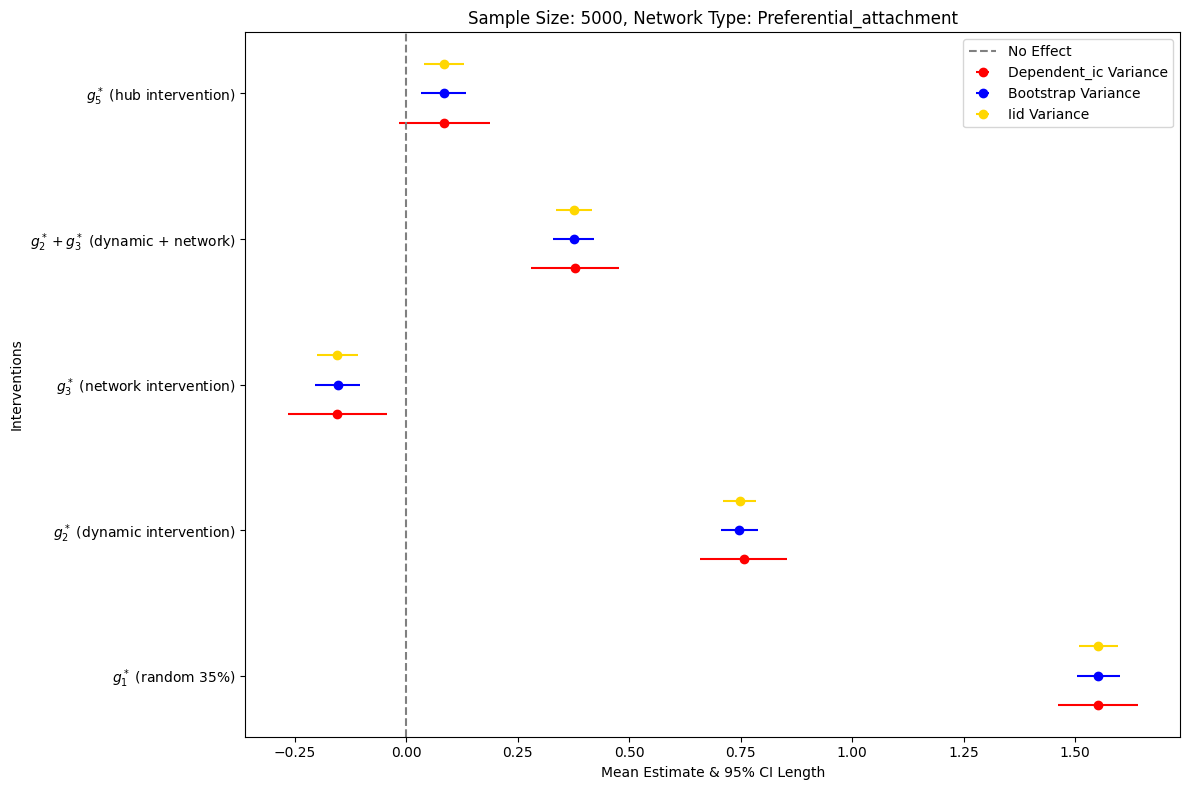

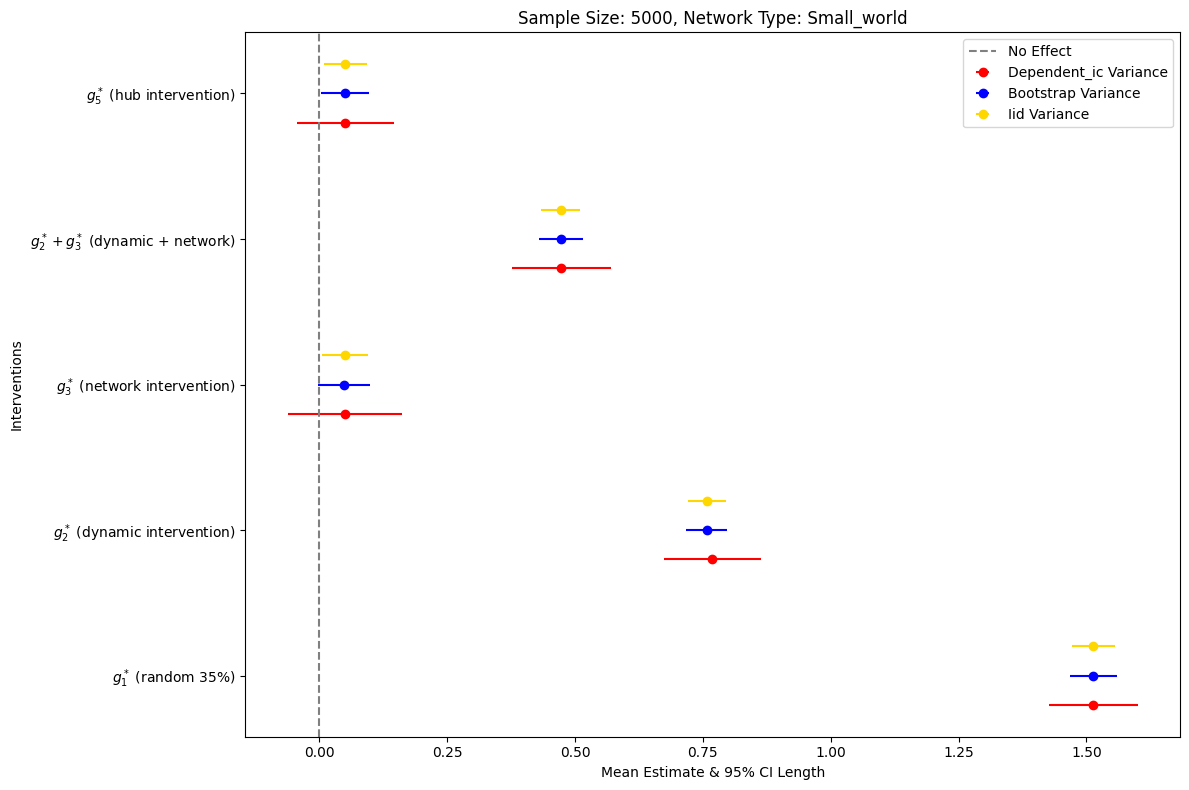

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data with High-Degree Influence
def simulate_network_data_with_hub_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # Identify hub nodes (top 10% by degree)
    hub_threshold = np.percentile(degrees, 90)
    data['is_hub'] = (degrees > hub_threshold).astype(int)

    # Neighbor treatment influence
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # High-degree treatment (more likely for hub nodes)
    treatment_prob_hub = 0.5 * data['is_hub'] + p_treatment * (1 - data['is_hub'])
    data['treatment_hub'] = np.random.binomial(1, treatment_prob_hub)

    # Outcome generation with high-degree influence
    hub_influence = data['is_hub'] * 2.0  # Amplified influence for hub nodes
    neighbor_effect = np.array([
        network_influence * np.sum(data.loc[list(G.neighbors(node)), 'treatment_combined']) / max(len(list(G.neighbors(node))), 1)
        for node in G.nodes
    ])
    data['outcome_with_hub_influence'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        neighbor_effect +
        hub_influence +
        np.random.normal(0, 1, n)
    )
    return data

# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=500):
    if method == 'dependent_ic':
        tmle_bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            effect, _, _ = estimate_tmle(
                sampled_data, treatment_col, outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            tmle_bootstrap_estimates.append(effect)
        mean_estimate = np.mean(tmle_bootstrap_estimates)
        variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        mean_estimate = np.mean(bootstrap_estimates)
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        mean_estimate = treated.mean() - untreated.mean()
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return mean_estimate, variance

# Visualization Function
def visualize_results_by_sample_and_network(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'treatment_hub': r"$g_5^*$ (hub intervention)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}

    sample_sizes = results_df['Sample Size'].unique()
    network_types = results_df['Network Type'].unique()

    for sample_size in sample_sizes:
        for network_type in network_types:
            subset = results_df[(results_df['Sample Size'] == sample_size) &
                                (results_df['Network Type'] == network_type)]

            plt.figure(figsize=(12, 8))
            for method in subset['Method'].unique():
                method_data = subset[subset['Method'] == method]
                y_positions = np.arange(len(method_data)) + method_offsets[method]

                plt.errorbar(
                    method_data['Effect'],
                    y_positions,
                    xerr=method_data['CI Length'],
                    fmt='o',
                    label=f"{method.capitalize()} Variance",
                    color=methods_colors[method]
                )

            plt.yticks(
                np.arange(len(subset['Intervention'].unique())),
                [interventions_labels[i] for i in subset['Intervention'].unique()]
            )
            plt.axvline(0, color='gray', linestyle='--', label="No Effect")
            plt.xlabel("Mean Estimate & 95% CI Length")
            plt.ylabel("Interventions")
            plt.title(f"Sample Size: {sample_size}, Network Type: {network_type.capitalize()}")
            plt.legend()
            plt.tight_layout()
            plt.show()

# Main Simulation Function
def run_simulation_with_hub_influence():
    sample_sizes = [500, 1000, 5000]
    interventions = [
        'treatment_random',
        'treatment_dynamic',
        'treatment_network',
        'treatment_combined',
        'treatment_hub'
    ]
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for n in tqdm(sample_sizes):
        for network_type in network_types:
            if network_type == 'preferential_attachment':
                G = generate_preferential_attachment_network(n, m=10, seed=42)
            elif network_type == 'small_world':
                G = generate_small_world_network(n, k=10, p=0.1, seed=42)

            data = simulate_network_data_with_hub_influence(G)
            for intervention in interventions:
                effect_tmle, variance_tmle, updated_data = estimate_tmle(
                    data, treatment_col=intervention, outcome_col='outcome_with_hub_influence',
                    covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
                )
                for method in variance_methods:
                    effect, variance = compute_variance(updated_data, intervention, 'outcome_with_hub_influence', method=method)
                    ci_length = 1.96 * np.sqrt(variance)
                    results.append({
                        'Sample Size': n,
                        'Network Type': network_type,
                        'Intervention': intervention,
                        'Method': method,
                        'Effect': effect,
                        'CI Length': ci_length,
                    })

    results_df = pd.DataFrame(results)
    visualize_results_by_sample_and_network(results_df)

# Run the Simulation
run_simulation_with_hub_influence()


Simulating Network Types: 100%|██████████| 2/2 [03:51<00:00, 115.82s/it]


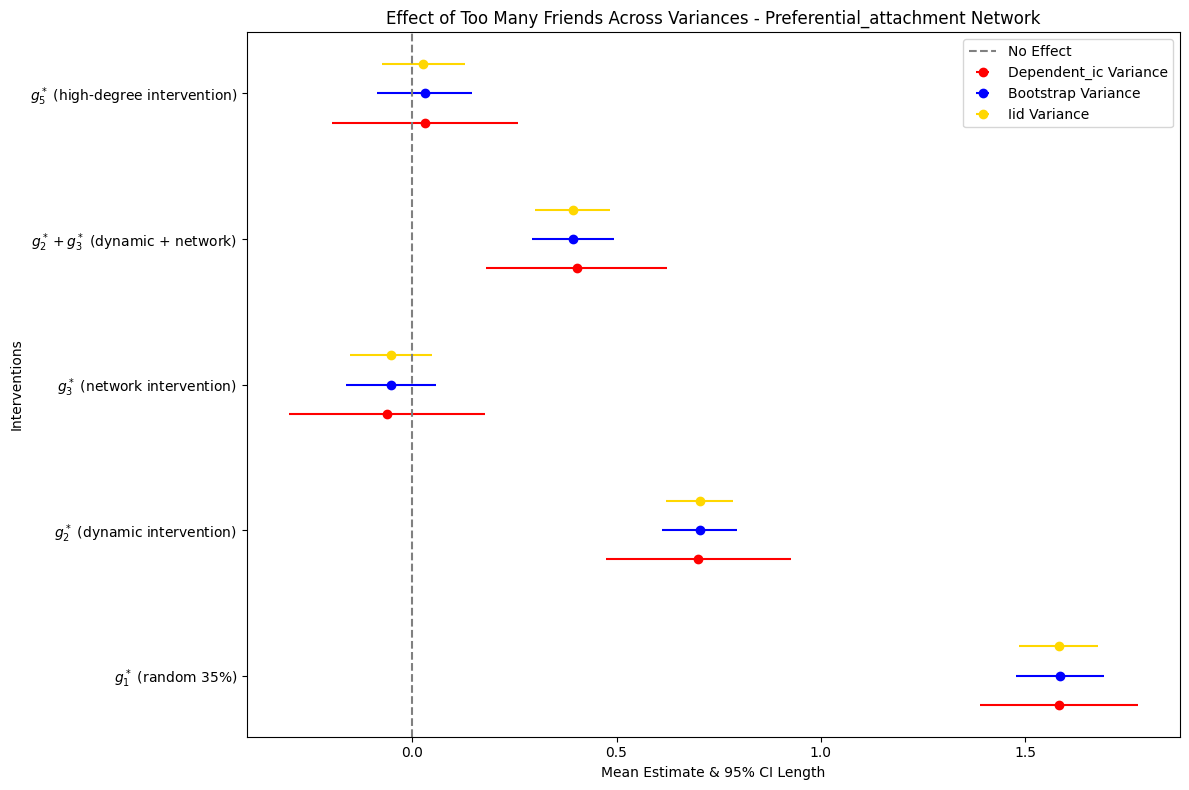

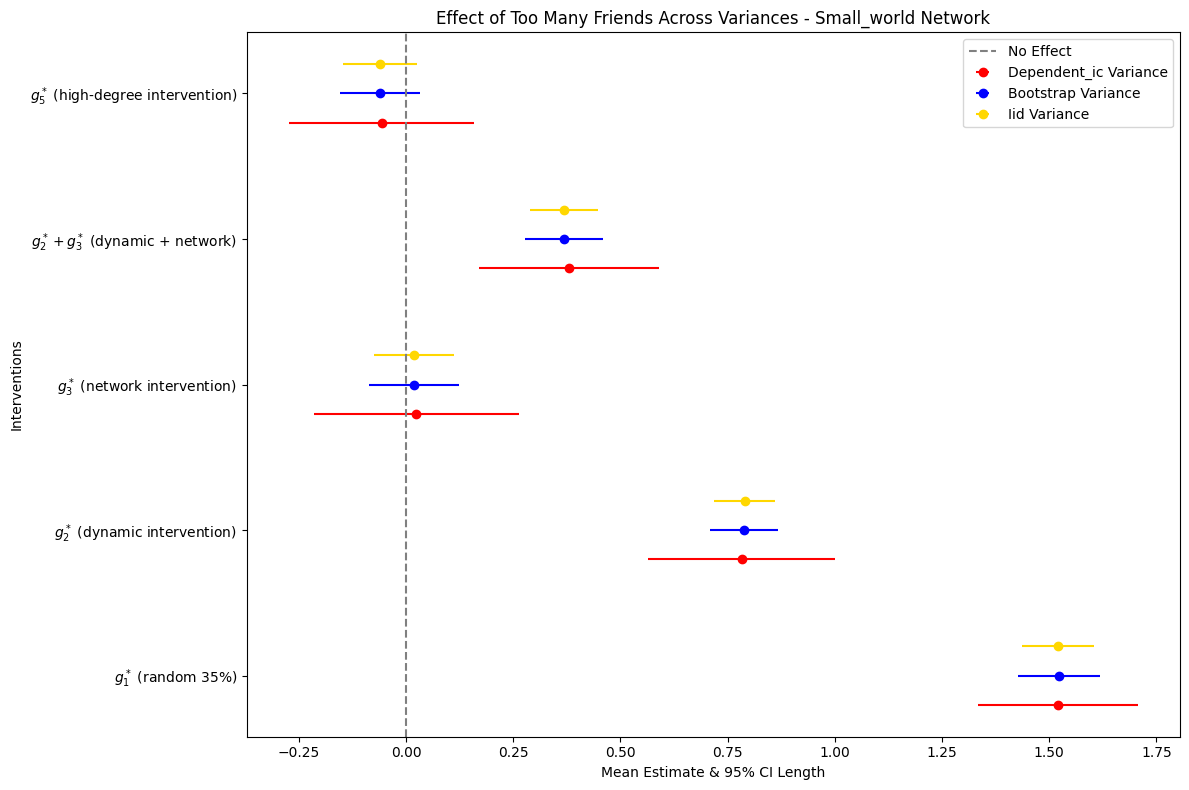

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data with High-Degree Influence
def simulate_network_data_with_hub_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # Identify hub nodes (top 10% by degree)
    hub_threshold = np.percentile(degrees, 90)
    data['is_hub'] = (degrees > hub_threshold).astype(int)

    # Neighbor treatment influence
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # High-degree treatment (more likely for hub nodes)
    treatment_prob_hub = 0.5 * data['is_hub'] + p_treatment * (1 - data['is_hub'])
    data['treatment_hub'] = np.random.binomial(1, treatment_prob_hub)

    # Outcome generation with high-degree influence
    hub_influence = data['is_hub'] * 2.0  # Amplified influence for hub nodes
    neighbor_effect = np.array([
        network_influence * np.sum(data.loc[list(G.neighbors(node)), 'treatment_combined']) / max(len(list(G.neighbors(node))), 1)
        for node in G.nodes
    ])
    data['outcome_with_hub_influence'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        neighbor_effect +
        hub_influence +
        np.random.normal(0, 1, n)
    )
    return data

# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=1000):
    if method == 'dependent_ic':
        tmle_bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            effect, _, _ = estimate_tmle(
                sampled_data, treatment_col, outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            tmle_bootstrap_estimates.append(effect)
        mean_estimate = np.mean(tmle_bootstrap_estimates)
        variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        mean_estimate = np.mean(bootstrap_estimates)
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        mean_estimate = treated.mean() - untreated.mean()
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return mean_estimate, variance

# Simulation for Preferential Attachment vs Small-World Networks
def simulate_preferential_vs_smallworld(network_size=1000, m_preferential=10, k_smallworld=10, p_smallworld=0.1):
    network_types = ['preferential_attachment', 'small_world']
    interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined', 'treatment_hub']
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    results = []

    for network_type in tqdm(network_types, desc="Simulating Network Types"):
        if network_type == 'preferential_attachment':
            G = generate_preferential_attachment_network(network_size, m=m_preferential, seed=42)
        elif network_type == 'small_world':
            G = generate_small_world_network(network_size, k=k_smallworld, p=p_smallworld, seed=42)

        # Simulate data with hub influence
        data = simulate_network_data_with_hub_influence(G)

        # Iterate over interventions and compute TMLE effects
        for intervention in interventions:
            effect_tmle, variance_tmle, updated_data = estimate_tmle(
                data, treatment_col=intervention, outcome_col='outcome_with_hub_influence',
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            for method in variance_methods:
                effect, variance = compute_variance(updated_data, intervention, 'outcome_with_hub_influence', method=method)
                ci_length = 1.96 * np.sqrt(variance)
                results.append({
                    'Network Type': network_type,
                    'Intervention': intervention,
                    'Method': method,
                    'Effect': effect,
                    'CI Length': ci_length,
                })

    return pd.DataFrame(results)

# Visualization
def visualize_too_many_friends_with_all_variances(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'treatment_hub': r"$g_5^*$ (high-degree intervention)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}
    network_types = results_df['Network Type'].unique()

    for network_type in network_types:
        subset = results_df[results_df['Network Type'] == network_type]

        plt.figure(figsize=(12, 8))
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            for idx, intervention in enumerate(method_data['Intervention'].unique()):
                intervention_data = method_data[method_data['Intervention'] == intervention]
                mean_effect = intervention_data['Effect'].values[0]
                ci_length = intervention_data['CI Length'].values[0]
                plt.errorbar(
                    mean_effect,
                    idx + method_offsets[method],
                    xerr=ci_length,
                    fmt='o',
                    label=f"{method.capitalize()} Variance" if idx == 0 else "",
                    color=methods_colors[method]
                )

        plt.yticks(
            range(len(subset['Intervention'].unique())),
            [interventions_labels[i] for i in subset['Intervention'].unique()]
        )
        plt.axvline(0, color='gray', linestyle='--', label="No Effect")
        plt.xlabel("Mean Estimate & 95% CI Length")
        plt.ylabel("Interventions")
        plt.title(f"Effect of Too Many Friends Across Variances - {network_type.capitalize()} Network")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run the Simulation
results_df = simulate_preferential_vs_smallworld(network_size=1000)

# Visualize Results
visualize_too_many_friends_with_all_variances(results_df)


Simulating Network Types: 100%|██████████| 2/2 [03:52<00:00, 116.17s/it]


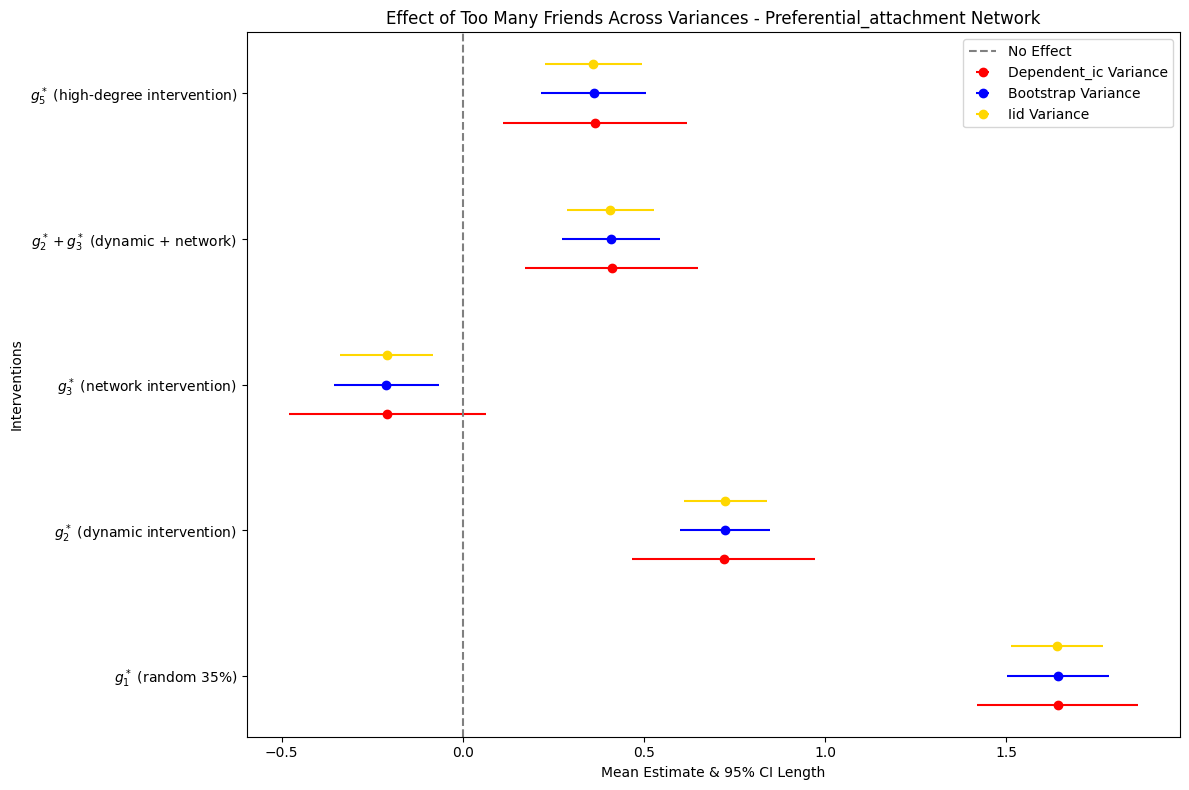

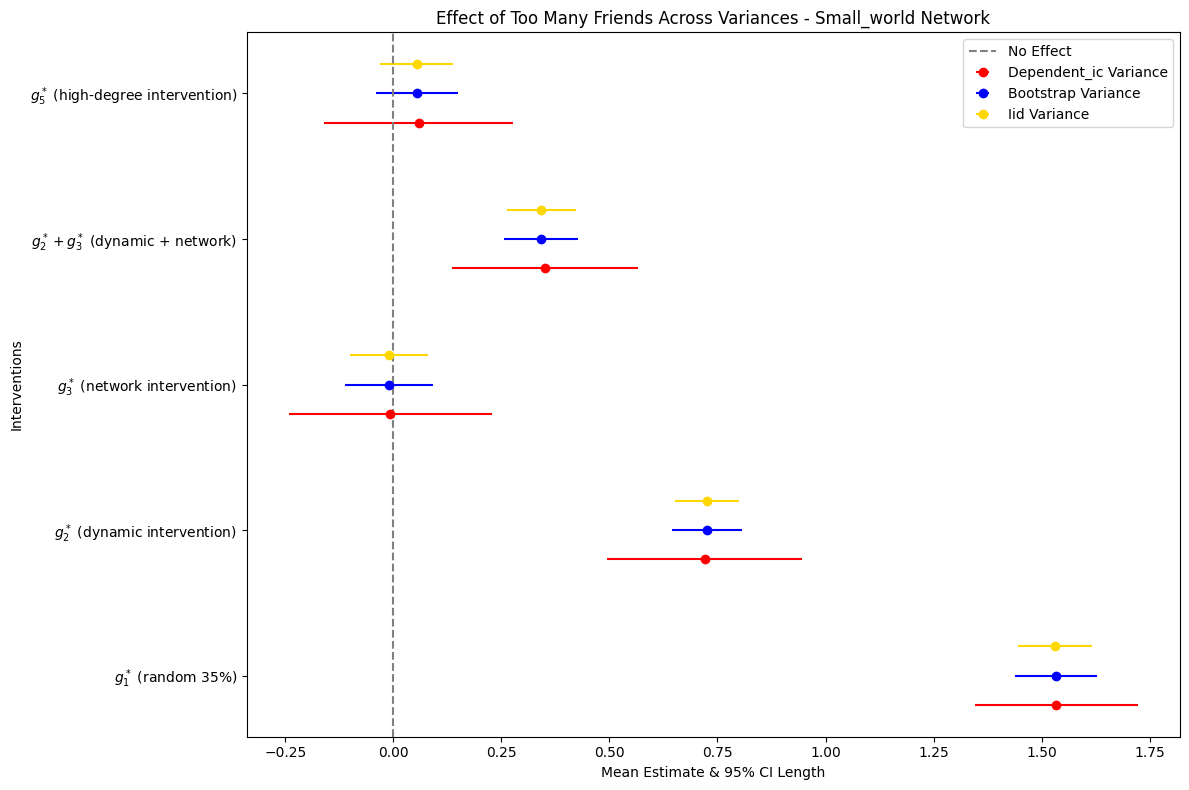

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data with High-Degree Influence
def simulate_network_data_with_hub_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # Identify hub nodes (top 10% by degree)
    hub_threshold = np.percentile(degrees, 90)
    data['is_hub'] = (degrees > hub_threshold).astype(int)

    # Neighbor treatment influence
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # High-degree treatment (more likely for hub nodes)
    treatment_prob_hub = 0.7 * data['is_hub'] + p_treatment * (1 - data['is_hub'])
    data['treatment_hub'] = np.random.binomial(1, treatment_prob_hub)

    # Outcome generation with amplified hub influence
    hub_influence = data['is_hub'] * 3.0  # Amplified influence for hub nodes
    neighbor_effect = np.array([
        network_influence * np.sum(data.loc[list(G.neighbors(node)), 'treatment_combined']) / max(len(list(G.neighbors(node))), 1)
        for node in G.nodes
    ])
    data['outcome_with_hub_influence'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        neighbor_effect +
        hub_influence +
        np.random.normal(0, 1, n)
    )
    return data

# Simulation for Preferential Attachment vs Small-World Networks
def simulate_preferential_vs_smallworld(network_size=1000, m_preferential=15, k_smallworld=8, p_smallworld=0.1):
    network_types = ['preferential_attachment', 'small_world']
    interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined', 'treatment_hub']
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    results = []

    for network_type in tqdm(network_types, desc="Simulating Network Types"):
        if network_type == 'preferential_attachment':
            G = generate_preferential_attachment_network(network_size, m=m_preferential, seed=42)
        elif network_type == 'small_world':
            G = generate_small_world_network(network_size, k=k_smallworld, p=p_smallworld, seed=42)

        # Simulate data with hub influence
        data = simulate_network_data_with_hub_influence(G)

        # Iterate over interventions and compute TMLE effects
        for intervention in interventions:
            effect_tmle, variance_tmle, updated_data = estimate_tmle(
                data, treatment_col=intervention, outcome_col='outcome_with_hub_influence',
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            for method in variance_methods:
                effect, variance = compute_variance(updated_data, intervention, 'outcome_with_hub_influence', method=method)
                ci_length = 1.96 * np.sqrt(variance)
                results.append({
                    'Network Type': network_type,
                    'Intervention': intervention,
                    'Method': method,
                    'Effect': effect,
                    'CI Length': ci_length,
                })

    return pd.DataFrame(results)

# Visualization: Same Format as Earlier
def visualize_too_many_friends_with_all_variances(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'treatment_hub': r"$g_5^*$ (high-degree intervention)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}
    network_types = results_df['Network Type'].unique()

    for network_type in network_types:
        subset = results_df[results_df['Network Type'] == network_type]

        plt.figure(figsize=(12, 8))
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            for idx, intervention in enumerate(method_data['Intervention'].unique()):
                intervention_data = method_data[method_data['Intervention'] == intervention]
                mean_effect = intervention_data['Effect'].values[0]
                ci_length = intervention_data['CI Length'].values[0]
                plt.errorbar(
                    mean_effect,
                    idx + method_offsets[method],
                    xerr=ci_length,
                    fmt='o',
                    label=f"{method.capitalize()} Variance" if idx == 0 else "",
                    color=methods_colors[method]
                )

        plt.yticks(
            range(len(subset['Intervention'].unique())),
            [interventions_labels[i] for i in subset['Intervention'].unique()]
        )
        plt.axvline(0, color='gray', linestyle='--', label="No Effect")
        plt.xlabel("Mean Estimate & 95% CI Length")
        plt.ylabel("Interventions")
        plt.title(f"Effect of Too Many Friends Across Variances - {network_type.capitalize()} Network")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run Simulation and Visualization
results_df = simulate_preferential_vs_smallworld(network_size=1000)
visualize_too_many_friends_with_all_variances(results_df)


Simulating Network Types: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


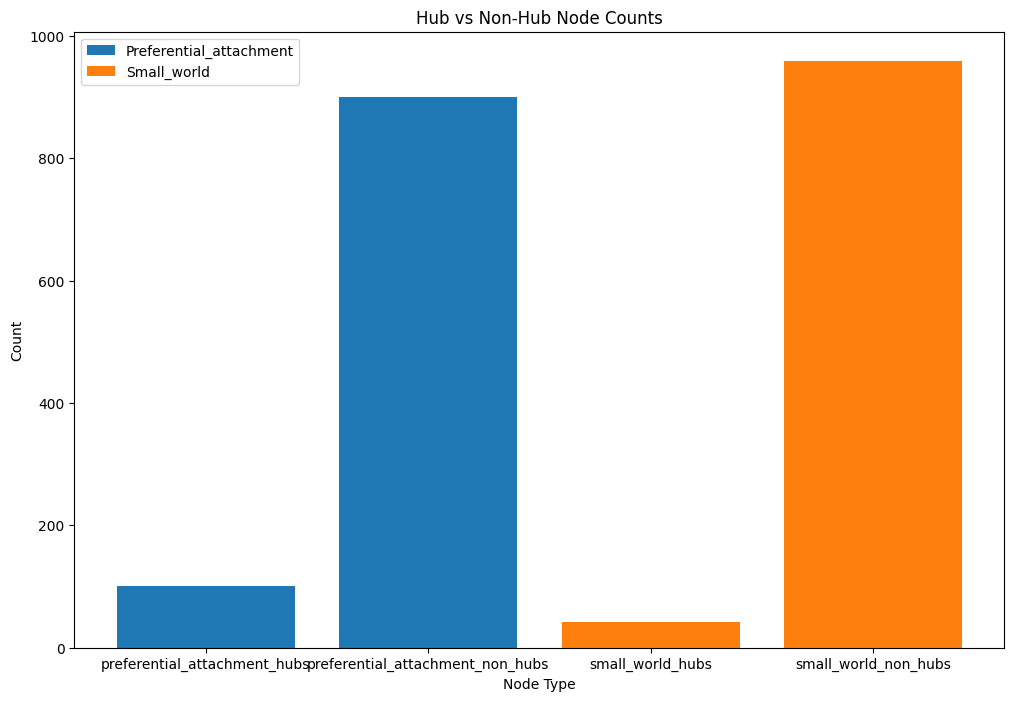

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Updated Simulation with Hub Conditioning
def simulate_network_data_with_hub_conditioning(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # Identify hub nodes (top K% by degree)
    hub_threshold = np.percentile(degrees, 90)  # Configurable threshold for top 10% degree nodes
    data['is_hub'] = (degrees > hub_threshold).astype(int)
    hubs = data[data['is_hub'] == 1].index
    non_hubs = data[data['is_hub'] == 0].index

    # Neighbor treatment influence (excluding hubs for non-hubs)
    neighbors_treatment = np.array([
        np.mean([
            latent_variable[neighbor]
            for neighbor in G.neighbors(node) if neighbor in non_hubs
        ]) if len([nbr for nbr in G.neighbors(node) if nbr in non_hubs]) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # High-degree treatment (hubs treated differently)
    treatment_prob_hub = 0.7 * data['is_hub'] + p_treatment * (1 - data['is_hub'])
    data['treatment_hub'] = np.random.binomial(1, treatment_prob_hub)

    # Outcome generation (conditional on hub presence)
    hub_influence = data['is_hub'] * 3.0  # Fixed influence for hubs
    neighbor_effect = np.array([
        network_influence * np.sum(data.loc[list(G.neighbors(node)), 'treatment_combined']) / max(len(list(G.neighbors(node))), 1)
        if node in non_hubs else 0
        for node in G.nodes
    ])
    data['outcome_with_hub_conditioning'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        neighbor_effect +
        hub_influence +
        np.random.normal(0, 1, n)
    )

    # Separate hubs for analysis
    hubs_data = data.loc[hubs]
    non_hubs_data = data.loc[non_hubs]

    return data, hubs_data, non_hubs_data

# Function to simulate and evaluate networks
def simulate_preferential_vs_smallworld_with_conditioning(network_size=1000, m_preferential=15, k_smallworld=8, p_smallworld=0.1):
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for network_type in tqdm(network_types, desc="Simulating Network Types"):
        if network_type == 'preferential_attachment':
            G = generate_preferential_attachment_network(network_size, m=m_preferential, seed=42)
        elif network_type == 'small_world':
            G = generate_small_world_network(network_size, k=k_smallworld, p=p_smallworld, seed=42)

        # Simulate data with hub conditioning
        data, hubs_data, non_hubs_data = simulate_network_data_with_hub_conditioning(G)

        # Collect statistics
        hub_count = len(hubs_data)
        non_hub_count = len(non_hubs_data)
        results.append({
            'Network Type': network_type,
            'Hub Count': hub_count,
            'Non-Hub Count': non_hub_count,
            'Average Degree (Hubs)': hubs_data['degree'].mean(),
            'Average Degree (Non-Hubs)': non_hubs_data['degree'].mean()
        })

    return pd.DataFrame(results)

# Visualization of Results
def visualize_hub_vs_nonhub(results_df):
    plt.figure(figsize=(12, 8))
    for network_type in results_df['Network Type'].unique():
        subset = results_df[results_df['Network Type'] == network_type]
        plt.bar(
            [network_type + "_hubs", network_type + "_non_hubs"],
            [subset['Hub Count'].values[0], subset['Non-Hub Count'].values[0]],
            label=f"{network_type.capitalize()}"
        )
    plt.xlabel("Node Type")
    plt.ylabel("Count")
    plt.title("Hub vs Non-Hub Node Counts")
    plt.legend()
    plt.show()

# Run Simulation and Visualization
results_df = simulate_preferential_vs_smallworld_with_conditioning(network_size=1000)
visualize_hub_vs_nonhub(results_df)


In [ ]:
import requests
import os
import time

# === Step 1: Create directories for data storage ===
os.makedirs('kegg_data/pathways', exist_ok=True)
os.makedirs('kegg_data/reactions', exist_ok=True)
os.makedirs('kegg_data/compounds', exist_ok=True)

# === Step 2: Download List of Pathways ===
print("Downloading list of pathways...")
pathway_url = 'http://rest.kegg.jp/list/pathway'
response = requests.get(pathway_url)
if response.status_code == 200:
    with open('kegg_data/kegg_pathways.txt', 'w') as file:
        file.write(response.text)

    # Extract pathway IDs from the list (like map00010, map00020, etc.)
    pathway_ids = []
    for line in response.text.strip().split('\n'):
        if ':' in line and '\t' in line:  # Check for properly formatted lines
            try:
                pathway_id = line.split('\t')[0].split(':')[1]
                pathway_ids.append(pathway_id)
            except IndexError:
                print(f"Skipping line due to IndexError: {line}")  # Debugging info
    pathway_ids = list(set(pathway_ids))  # Remove duplicates
    print(f"Extracted {len(pathway_ids)} pathway IDs successfully.")
else:
    print("Failed to download list of pathways.")

# === Step 3: Download Details for Each Pathway ===
print(f"Downloading details for {len(pathway_ids)} pathways...")
for pathway in pathway_ids:
    url = f'http://rest.kegg.jp/get/{pathway}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(f'kegg_data/pathways/{pathway}.txt', 'w') as file:
                file.write(response.text)
        else:
            print(f"Failed to download pathway {pathway}")
    except Exception as e:
        print(f"Error downloading pathway {pathway}: {e}")
    time.sleep(1)  # To avoid overloading the KEGG server

# === Step 4: Download List of Reactions ===
print("Downloading list of reactions...")
reaction_url = 'http://rest.kegg.jp/list/reaction'
response = requests.get(reaction_url)
if response.status_code == 200:
    with open('kegg_data/kegg_reactions.txt', 'w') as file:
        file.write(response.text)

    # Extract reaction IDs (like R00001, R00002, etc.)
    reaction_ids = []
    for line in response.text.strip().split('\n'):
        if ':' in line and '\t' in line:  # Check if the line has both ":" and "\t"
            try:
                reaction_id = line.split('\t')[0].split(':')[1]
                reaction_ids.append(reaction_id)
            except IndexError:
                print(f"Skipping line due to IndexError: {line}")  # Debugging info
    reaction_ids = list(set(reaction_ids))  # Remove duplicates
    print(f"Extracted {len(reaction_ids)} reaction IDs successfully.")
else:
    print("Failed to download list of reactions.")

# === Step 5: Download Details for Each Reaction ===
print(f"Downloading details for {len(reaction_ids)} reactions...")
for reaction in reaction_ids:
    url = f'http://rest.kegg.jp/get/{reaction}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(f'kegg_data/reactions/{reaction}.txt', 'w') as file:
                file.write(response.text)
        else:
            print(f"Failed to download reaction {reaction}")
    except Exception as e:
        print(f"Error downloading reaction {reaction}: {e}")
    time.sleep(1)  # To avoid overloading the KEGG server

# === Step 6: Download List of Compounds ===
print("Downloading list of compounds...")
compound_url = 'http://rest.kegg.jp/list/compound'
response = requests.get(compound_url)
if response.status_code == 200:
    with open('kegg_data/kegg_compounds.txt', 'w') as file:
        file.write(response.text)

    # Extract compound IDs (like C00002, C00008, etc.)
    compound_ids = []
    for line in response.text.strip().split('\n'):
        if ':' in line and '\t' in line:  # Check for properly formatted lines
            try:
                compound_id = line.split('\t')[0].split(':')[1]
                compound_ids.append(compound_id)
            except IndexError:
                print(f"Skipping line due to IndexError: {line}")  # Debugging info
    compound_ids = list(set(compound_ids))  # Remove duplicates
    print(f"Extracted {len(compound_ids)} compound IDs successfully.")
else:
    print("Failed to download list of compounds.")

# === Step 7: Download Details for Each Compound ===
print(f"Downloading details for {len(compound_ids)} compounds...")
for compound in compound_ids:
    url = f'http://rest.kegg.jp/get/{compound}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(f'kegg_data/compounds/{compound}.txt', 'w') as file:
                file.write(response.text)
        else:
            print(f"Failed to download compound {compound}")
    except Exception as e:
        print(f"Error downloading compound {compound}: {e}")
    time.sleep(1)  # To avoid overloading the KEGG server

print("\n✅ KEGG Data Download Complete!")
print("Data has been saved in the 'kegg_data' folder.")


Streaming output truncated to the last 5000 lines.
Skipping line due to IndexError: R02691	UDP-alpha-D-galactose:1,2-diacyl-sn-glycerol 3-beta-D-galactosyltransferase; UDP-alpha-D-galactose + 1,2-Diacyl-sn-glycerol <=> UDP + 1,2-Diacyl-3-beta-D-galactosyl-sn-glycerol
Skipping line due to IndexError: R02692	1,2-diacyl-sn-glycerol:sterol O-acyltransferase; 1,2-Diacyl-sn-glycerol + Cholesterol <=> 1-Acylglycerol + Cholesterol ester
Skipping line due to IndexError: R02693	1,2-diacyl-sn-glycerol:sterol O-acyltransferase; 1,2-Diacyl-sn-glycerol + Sterol <=> 1-Acylglycerol + Steryl ester
Skipping line due to IndexError: R02694	2,3-dehydroacyl-CoA:1,2-diacylglycerol O-acyltransferase; 2,3-Dehydroacyl-CoA + 1,2-Diacyl-sn-glycerol <=> CoA + Triacylglycerol
Skipping line due to IndexError: R02695	4-hydroxyphenylacetaldehyde:NAD+ oxidoreductase; 4-Hydroxyphenylacetaldehyde + NAD+ + H2O <=> 4-Hydroxyphenylacetate + NADH + H+
Skipping line due to IndexError: R02697	4-hydroxyphenylacetaldehyde:NADP+ 

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt


# === Load KEGG Data ===
def load_kegg_data():
    pathways = pd.read_csv('kegg_data/kegg_pathways.txt', sep='\t', header=None, names=['Pathway', 'Reaction'])
    reactions = pd.read_csv('kegg_data/kegg_reactions.txt', sep='\t', header=None, names=['Reaction', 'Compound'])
    compounds = pd.read_csv('kegg_data/kegg_compounds.txt', sep='\t', header=None, names=['Compound', 'Description'])
    return pathways, reactions, compounds


# === Create KEGG Network ===
def create_kegg_network(pathways, reactions):
    G = nx.Graph()
    for _, row in pathways.iterrows():
        G.add_edge(row['Pathway'], row['Reaction'])
    for _, row in reactions.iterrows():
        G.add_edge(row['Reaction'], row['Compound'])
    return G


# === Extract Node Features from KEGG Network ===
def extract_node_features(G):
    nodes = list(G.nodes)
    data = pd.DataFrame(index=nodes)

    # Extract features for each node
    data['degree'] = pd.Series(dict(G.degree))
    data['betweenness'] = pd.Series(nx.betweenness_centrality(G))
    data['closeness'] = pd.Series(nx.closeness_centrality(G))
    data['eigenvector'] = pd.Series(nx.eigenvector_centrality(G, max_iter=1000))

    # Extract node type (pathway, reaction, or compound)
    data['node_type'] = [determine_node_type(node) for node in nodes]

    # One-hot encode the node type (pathway, reaction, compound, unknown)
    data = pd.get_dummies(data, columns=['node_type'], drop_first=True)

    return data


def determine_node_type(node):
    if node.startswith('path:'):
        return 'pathway'
    elif node.startswith('rn:'):
        return 'reaction'
    elif node.startswith('cpd:'):
        return 'compound'
    else:
        return 'unknown'


# === Assign Treatment (Natural, Not Simulated) ===
def assign_treatment(data):
    # Assign treatment based on node properties
    data['treatment'] = (data['degree'] > data['degree'].quantile(0.75)).astype(int)
    return data


# === TMLE Estimation ===
def estimate_tmle(data, treatment_col='treatment', outcome_col='degree', covariates=None):
    if covariates is None:
        covariates = ['betweenness', 'closeness', 'eigenvector'] + [col for col in data.columns if 'node_type_' in col]

    # Exposure model (logistic regression)
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model (linear regression)
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    effect = data.loc[data[treatment_col] == 1, 'Y_tilde'].mean() - data.loc[data[treatment_col] == 0, 'Y_tilde'].mean()
    return effect, data


# === Bootstrap Variance Estimation (Dependent & IID) ===
def compute_bootstrap_variance(data, treatment_col='treatment', outcome_col='degree', n_bootstrap=100):
    tmle_effects = []
    iid_effects = []

    for _ in range(n_bootstrap):
        sampled_data = resample(data)

        # Dependent case: re-run TMLE
        tmle_effect, _ = estimate_tmle(sampled_data, treatment_col, outcome_col)
        tmle_effects.append(tmle_effect)

        # IID case: treat nodes as independent
        treated = sampled_data[sampled_data[treatment_col] == 1]['degree']
        untreated = sampled_data[sampled_data[treatment_col] == 0]['degree']
        iid_effect = treated.mean() - untreated.mean()
        iid_effects.append(iid_effect)

    return np.mean(tmle_effects), np.var(tmle_effects), np.mean(iid_effects), np.var(iid_effects)


# === Main Analysis Function ===
def run_analysis():
    pathways, reactions, compounds = load_kegg_data()
    G = create_kegg_network(pathways, reactions)
    print(f"Loaded KEGG network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Extract node-level features
    data = extract_node_features(G)
    data = assign_treatment(data)

    # Perform TMLE analysis
    treatment_col = 'treatment'
    effect_tmle, updated_data = estimate_tmle(data, treatment_col=treatment_col, outcome_col='degree')

    # Compute variance for both dependent (TMLE) and IID approaches
    mean_tmle, var_tmle, mean_iid, var_iid = compute_bootstrap_variance(updated_data, treatment_col=treatment_col, outcome_col='degree', n_bootstrap=100)

    # Compute 95% CI for both TMLE and IID variance
    ci_tmle = (mean_tmle - 1.96 * np.sqrt(var_tmle), mean_tmle + 1.96 * np.sqrt(var_tmle))
    ci_iid = (mean_iid - 1.96 * np.sqrt(var_iid), mean_iid + 1.96 * np.sqrt(var_iid))

    results = {
        'Treatment': treatment_col,
        'TMLE Effect': mean_tmle,
        'TMLE Variance': var_tmle,
        'TMLE 95% CI': ci_tmle,
        'IID Effect': mean_iid,
        'IID Variance': var_iid,
        'IID 95% CI': ci_iid,
    }

    print("\n=== Results Summary ===")
    print(results)
    return results


# === Run the Analysis ===
if __name__ == "__main__":
    results = run_analysis()


Loaded KEGG network with 25473 nodes and 12744 edges.

=== Results Summary ===
{'Treatment': 'treatment', 'TMLE Effect': 1.0, 'TMLE Variance': 1.035379938102578e-32, 'TMLE 95% CI': (0.9999999999999998, 1.0000000000000002), 'IID Effect': 1.0, 'IID Variance': 0.0, 'IID 95% CI': (1.0, 1.0)}
